In [1]:
%load_ext autoreload
%autoreload 2
# %matplotlib widget
# %matplotlib inline


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.dates as mdates
import pvcircuit as pvc
from scipy import constants
from scipy.optimize import curve_fit, fsolve
from scipy.special import erfc
import itertools

from pvcircuit.physics_helpers import fit_sandia_simple
from pvlib.pvsystem import singlediode
import pvlib

import os
import sys

from glob import glob
from datetime import datetime, timedelta
import time
from tqdm.notebook import trange
import timeit
import pickle

# set path for NREL meteorological package and import
sys.path.append("../../NREL_Meteorological")
from environmental import Spectra, Meteorological, sync, CloudCover, CloudImageLoader
import warnings
from scipy.optimize import OptimizeWarning
import pickle
from scipy.interpolate import interp1d


c:\users\rwitteck\documents\coding\python\pvcircuit_fork\pvcircuit\EY.py:17: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [3]:
def get_figsize(width_pt=396, fraction = 1, ratio=(5**.5 - 1) / 2, rows=1, cols=1):
    """Set figure dimensions to avoid scaling in LaTeX.

    Parameters
    ----------
    width: float or string
            Document width in points, or string of predined document type
    fraction: float, optional
            Fraction of the width which you wish the figure to occupy
     ratio: float, optional
            Golden ratio to set aesthetic figure height
            https://disq.us/p/2940ij3
            golden_ratio = (5**.5 - 1) / 2
    rows: subplot rows
    cols: subplot cols
    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """

    # Width of figure (in pts)
    fig_width_pt = width_pt * fraction
    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in * ratio * (rows / cols)

    return (fig_width_in, fig_height_in)


In [4]:
FIG_WIDTH_ONECOL = 246
FIG_WIDTH_TWOCOL = 510
EXPORT_DPI = 600
EXPORT_FMT = 'pdf'

In [5]:
# style_path = r"C:\Users\rwitteck\.matplotlib\mystyles\mystyle.mplstyle"
mpl.style.reload_library()
plt.style.use('default')
# plt.style.use('mystyle')



In [6]:
# mpl.rc("figure",figsize=get_figsize(FIG_WIDTH))
fig_onecol = get_figsize(FIG_WIDTH_ONECOL, fraction = 1, ratio=1,rows=1,cols=1)
fig_twocol = get_figsize(FIG_WIDTH_TWOCOL, fraction = 1, ratio=1,rows=1,cols=1)

fig_settings = {
    # "figure.figsize":get_figsize(396),
    # Use LaTeX to write all text
    "text.usetex": False,
    "font.family": "sans-serif",
    "font.sans-serif": "Arial",
    # Use 9pt font arial in plots, to match 10pt font in document latex CM
    "axes.titlesize": 9,
    "axes.labelsize": 9,
    "axes.linewidth": 1.5,
    "font.size": 10,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 8,
    "xtick.labelsize": 8,
    "xtick.major.width": 1.5,
    "xtick.minor.width": 1.3,
    "ytick.major.width": 1.5,
    "ytick.minor.width": 1.3,
    "ytick.labelsize": 8,

    "savefig.transparent": True,

    "pgf.texsystem": "lualatex",
    "pgf.rcfonts": False,     # don't setup fonts from rc parameters,
    # 'pgf.preamble': "\n".join([
        #  r"\usepackage[T1]{fontenc}",   # unicode math setup
    # ]),
}

plt.rcParams.update(fig_settings)

In [7]:
warnings.simplefilter("ignore", OptimizeWarning)
style2T = dict(marker='*', lw=0, color=(0.0,0.0,0.8, 1), mec=(0.0,0.0,1.0,0.8), mew=1, ms=8)
style4T = dict(marker='o', lw=0, color=(0.8,0.0,0.0, 1), mec=(1,0.0,0.0,0.8), mew=1, ms=5)

### EY analysis for the location in Golden using average photon energy (APE) binning



Helpers


In [8]:
def wavelength_to_photonenergy(wavelength):
    return constants.h * constants.c / (wavelength * 1e-9) / constants.e


def photonenergy_to_wavelength(photonenergy):
    return constants.h * constants.c / (photonenergy * 1e-9) / constants.e


def _normalize(eqe: pd.DataFrame) -> pd.DataFrame:
    eqe_min = np.nanmin(eqe)
    eqe_max = np.nanmax(eqe)
    return (eqe - eqe_min) / (eqe_max - eqe_min)


def _eq_solve_Eg(Eg, *data):
    x, y = data
    return np.trapz(x * y, x) / np.trapz(y, x) - Eg


def _gaussian(x, a, x0, sigma):
    return 1 * np.exp(-((x - x0) ** 2) / (2 * sigma**2))


def calc_Eg_Rau(eqe, fit_gaussian=True):
    # using [1] U. Rau, B. Blank, T. C. M. Müller, and T. Kirchartz,
    # “Efficiency Potential of Photovoltaic Materials and Devices Unveiled by Detailed-Balance Analysis,”
    # Phys. Rev. Applied, vol. 7, no. 4, p. 044016, Apr. 2017, doi: 10.1103/PhysRevApplied.7.044016.
    # extended by gaussian fit

    # Define the Gaussian function
    wavelength = eqe.index.values
    y = eqe.values
    x = wavelength_to_photonenergy(wavelength)

    # convert wavelength to photon energy
    y_grad = np.abs(np.gradient(y))
    # y_grad = np.abs(np.diff(y.values, prepend=np.nan))
    # y_grad = y.diff().abs().values

    # filter tail to avoid eqe dips at end/beginning of measurement
    y_grad = y_grad[(x < (x.max() + x.min())/2)]
    y = y[(x < (x.max() + x.min())/2)]
    x = x[(x < (x.max() + x.min())/2)]
    # normalize data
    y_grad = _normalize(y_grad)
    # get the index of the maximum
    y_diff_max_idx = np.nanargmax(y_grad)
    # get the max coordinates
    x_diff_max = x[y_diff_max_idx]
    y_diff_max = y_grad[y_diff_max_idx]

    # define lower threshold
    p_ab = np.exp(-2) * y_diff_max
    thres = 0.5
    # p_ab = thres * y_diff_max
    # find the index of the low-energy side where P(a) is max(P(Eg)/2)
    a_cond = np.where((y_grad < p_ab) & (x < x_diff_max))[0]
    if len(a_cond > 0):
        a_idx = np.nanmin(a_cond)
    else:
        a_idx = len(x) - 1
    a = x[a_idx]
    p_a = y_grad[a_idx]
    # find the index of the high-energy side where P(b) is max(P(Eg)/2)
    b_idx = np.nanmax(np.where((y_grad < p_ab) & (x > x_diff_max))[0])
    b = x[b_idx]
    p_b = y_grad[b_idx]

    x_target = x[a_idx : b_idx - 1 : -1]
    y_target = y_grad[a_idx : b_idx - 1 : -1]

    if fit_gaussian:

        # initial guesses from weighted arithmetic mean and weighted sample sigma
        mean = sum(x_target * y_target) / sum(y_target)
        sigma = np.sqrt(sum(y_target * (x_target - mean) ** 2) / sum(y_target))

        fit_res = curve_fit(
            _gaussian,
            x_target,
            y_target,
            p0=[max(y_target), mean, sigma],
        )
        x_fit = np.linspace(x[b_idx], x[a_idx], 100)
        y_fit = _gaussian(x_fit, *fit_res[0])

        # fig,ax = plt.subplots(1)
        # ax.plot(x, y_grad,'.')
        # ax.plot(x_fit, y_fit)
        # ax.plot(x_target, y_target, ".r")
        # ax.plot(x_diff_max, y_diff_max, "r*")
        # ax.plot(a, p_a, "g*")
        # ax.plot(b, p_b, "b*")
        # plt.plot(x_fit - fit_res[0][1], y_fit)
        # plt.plot(x_fit, y_fit)
        # ax.set_xlim(1.1, 1.8)
        # ax.set_ylabel(r"$\frac{{\mathrm{d}}EQE}{{\mathrm{d}}E_{\nu}}$")
        # ax.set_xlabel(r"Photon energy $E_{\nu}$ [eV]")

        x_fit = x_fit[y_fit >= thres * y_fit.max()]
        y_fit = y_fit[y_fit >= thres * y_fit.max()]
        sigma = fit_res[0][2]

    else:
        fit_res = [None]
        x_fit = x_target
        y_fit = y_target
        sigma = None

    res = fsolve(_eq_solve_Eg, 1.0, args=(x_fit, y_fit))
    bandgap = res[0]
    return bandgap, sigma


def si_eg_shift(temperature, bandgap_25):
    p = [-6.47214956e-04, 1.01632828e00]
    return (p[0] * temperature + p[1]) * bandgap_25


def si_sigma_shift(temperature, sigma_25):
    p = [0.00959188, 0.76558903]
    return (p[0] * temperature + p[1])*sigma_25


def psc_eg_shift(temperature, bandgap_25):
    t_split = 32
    p = [2.59551019e-04, 9.91138163e-01]
    res = np.zeros_like(temperature)

    t_filter = temperature > t_split
    res[t_filter] = p[0] * temperature[t_filter] + p[1]
    res[~t_filter] = p[0] * t_split + p[1]
    # res = pd.Series(res, index = temperature.index)
    return res * bandgap_25


def psc_sigma_shift(temperature, sigma_25):
    p = [0.00358866, 0.90074156]
    return (p[0] * temperature + p[1])*sigma_25

def integrate_eqe(eqe, spectra = None):
    
    if spectra is None:
        path_to_am15_spectra = os.path.join(os.path.dirname(os.getcwd()), "data","ASTMG173.csv")  # Data files here
        # spectra = pd.read_csv(path_to_am15_spectra, header=[*range(0,3)])
        spectra_full = pd.read_csv(path_to_am15_spectra, header=[2])
        spectra_full.set_index(spectra_full.columns[0], inplace=True)

        # spectra = spectra_full.reindex(eqe.index)
        # if spectra.isnull().any(axis=1).any():
        #     spectra = spectra.reindex(index=eqe.index).interpolate(method="index")
            
        spectra = spectra_full["global"]

    # jsc = (
    #     eqe.apply(lambda x: np.trapz(y=x * spectra["global"] / qe._wavelength_to_photonenergy(eqe.index), x=eqe.index)) / 10
    # )
    spec_interp_func = interp1d(spectra.index, spectra,axis=0)
    spectra_interp = pd.DataFrame(spec_interp_func(eqe.index.astype(np.float64)).astype(np.float64), index = eqe.index)
    
    jsc = np.trapz(y=eqe.values.reshape(-1,1) * spectra_interp.values / wavelength_to_photonenergy(eqe.index.values.reshape(-1,1)), x=eqe.index.values.reshape(-1,1),axis=0) / 10
    
    
    return jsc
    si_fit = np.polyfit(temperature_silicon, jsc[1:], 1)

    temps = np.linspace(min(temperature_silicon), max(temperature_silicon), 50)
    jsc_fit = np.polyval(si_fit, temps)

    fig, ax = plt.subplots(1)
    ax.plot(temperature_silicon, jsc[1:], "*", temps, jsc_fit)

# @numba.jit()
def shift_eqe(eqe_ref, bandgap_25, sigma_25, bandgaps, sigmas, spectra):

    eqe = eqe_ref.values
    lam = eqe_ref.index.values
    Ey = constants.h * constants.c / (lam * 1e-9) / constants.e  # [eV]
    
    # abs = 1 / 2 * erfc((bandgap_25 - Ey) / (sigma_25 * np.sqrt(2)))

    lam_eqe_saturation_idx = np.argmax(eqe * lam)
    eqe_saturation = eqe[lam_eqe_saturation_idx]
    # lam_eqe_saturation = lam[lam_eqe_saturation_idx]

    # jscs = []
    # # fig,ax = plt.subplots()
    # for i, col in enumerate(bandgaps):
    #     # print(qe_data.temperature)
    #     spec = spectra.iloc[i][lam]
    #     bandgap = bandgaps[i]
    #     sigma = sigmas[i]
    #     abs = 1 / 2 * erfc((bandgap - Ey) / (sigma * np.sqrt(2))) * eqe_saturation
    #     eqe_filter = lam > photonenergy_to_wavelength(bandgap + 2*sigma)
    #     eqe_new = np.concatenate([eqe[~eqe_filter],abs[eqe_filter]])
    #     # ax.plot(eqe_new)
    #     jscs.append(np.trapz(y = eqe_new * spec / wavelength_to_photonenergy(spec.index), x = spec.index) / 10)
    
    if len(spectra) > 1:
        spec_interp_func = interp1d(spectra.index, spectra,axis=0)

        spectra_interp = pd.DataFrame(spec_interp_func(spectra.index.astype(np.float64)).astype(np.float64), index = spectra.index.astype(np.float64))

    else:
        spectra_interp = spectra.T
        
    bandgaps_arr = np.tile(bandgaps, [len(Ey), 1])
    sigmas_arr = np.tile(sigmas, [len(Ey), 1])
    erfc_arr = (bandgaps_arr - Ey.reshape(-1,1)) / (sigmas_arr * np.sqrt(2))
    vec_erfc = np.vectorize(erfc)
    abs_arr = vec_erfc(erfc_arr) * 0.5 * eqe_saturation
    eqe_filter = np.tile(lam,[len(bandgaps),1]).T > photonenergy_to_wavelength(bandgaps_arr + 2*sigmas_arr)
    eqe_new_arr = np.tile(eqe,[len(bandgaps),1]).T    
    eqe_new_arr = eqe_new_arr * ~eqe_filter + abs_arr * eqe_filter
    # jscs = np.trapz(y = eqe_new_arr * spectra[lam].values.T  / wavelength_to_photonenergy(lam).reshape(-1,1), x = lam.reshape(-1,1),axis=0) / 10
    jscs = np.trapz(y = eqe_new_arr * spectra_interp.loc[lam].values.reshape(-1,1)  / wavelength_to_photonenergy(lam).reshape(-1,1), x = lam.reshape(-1,1),axis=0) / 10
    
    # print(f"check jscs = {all(jscs_arr == np.array(jscs))}")
    
    return jscs
    
def shift_eqe_tcbc(tc_eqe_ref, tc_bandgap_25, tc_sigma_25, tc_bandgaps, tc_sigmas, bc_eqe_ref, bc_bandgap_25, bc_sigma_25, bc_bandgaps, bc_sigmas, spectra):

    vec_erfc = np.vectorize(erfc)
    tc_trans = None
    # in case values are percentages
    
    lam = tc_eqe_ref.index.values
    
    tc_eqe = tc_eqe_ref.values
    tc_Ey = constants.h * constants.c / (lam * 1e-9) / constants.e  # [eV]
    
    tc_lam_eqe_saturation_idx = np.argmax(tc_eqe * lam)
    tc_eqe_saturation = tc_eqe[tc_lam_eqe_saturation_idx]
    # using 25 degC EQE for saturation
    tc_eqe_saturation = tc_eqe_ref[lam > photonenergy_to_wavelength(tc_bandgap_25 + 2*tc_sigma_25)].iloc[0]
    
    bc_eqe = bc_eqe_ref.values
    bc_Ey = constants.h * constants.c / (lam * 1e-9) / constants.e  # [eV]
    
    bc_lam_eqe_saturation_idx = np.argmax(bc_eqe * lam)
    bc_eqe_saturation = bc_eqe[bc_lam_eqe_saturation_idx]
    # using 25 degC EQE for saturation
    bc_eqe_saturation = bc_eqe_ref[lam > photonenergy_to_wavelength(bc_bandgap_25 + 2*bc_sigma_25)].iloc[0]
    
    # if len(spectra) > 1:
    #     spec_interp_func = interp1d(spectra.index, spectra,axis=0)
    #     spectra_interp = pd.DataFrame(spec_interp_func(spectra.index.astype(np.float64)).astype(np.float64), index = spectra.index.astype(np.float64))

    # else:
    #     spectra_interp = spectra.T
        
    tc_bandgaps_arr = np.tile(tc_bandgaps, [len(tc_Ey), 1])
    tc_sigmas_arr = np.tile(tc_sigmas, [len(tc_Ey), 1])
    tc_erfc_arr = (tc_bandgaps_arr - tc_Ey.reshape(-1,1)) / (tc_sigmas_arr * np.sqrt(2))
    tc_eqe_filter = np.tile(lam,[len(tc_bandgaps),1]).T > photonenergy_to_wavelength(tc_bandgaps_arr + 2*tc_sigmas_arr)
    tc_eqe_new_arr = np.tile(tc_eqe,[len(tc_bandgaps),1]).T    
    tc_abs_arr = vec_erfc(tc_erfc_arr) * 0.5 * tc_eqe_saturation
    # tc_abs_arr = vec_erfc(tc_erfc_arr) * 0.5 * np.tile(tc_eqe_new_arr[tc_eqe_filter.argmax(axis=0),:].reshape(1,-1), (tc_eqe_new_arr.shape[0],1))
    tc_eqe_new_arr = tc_eqe_new_arr * ~tc_eqe_filter + tc_abs_arr * tc_eqe_filter
    
    # fig,ax = plt.subplots()
    # ax.plot(lam,tc_abs_arr[:,0], "k--")
    # ax.plot(lam,tc_eqe_new_arr[:,0] * ~tc_eqe_filter[:,0], "r--")
    # ax.plot(lam,tc_abs_arr[:,0] * tc_eqe_filter[:,0], "b--")
    # ax.plot(lam,tc_eqe_ref, "m-")
    
    
    
    tc_trans = None
    if tc_trans is None:
        tc_trans = 1 - _normalize(tc_eqe_new_arr)
    
    eqe_max_idx = np.argmax(tc_eqe_new_arr,axis=0)
    filter_idx = (tc_eqe_new_arr < 0.01) & (tc_eqe_new_arr > eqe_max_idx)
    tc_trans[filter_idx] = 1
    
    
    bc_bandgaps_arr = np.tile(bc_bandgaps, [len(bc_Ey), 1])
    bc_sigmas_arr = np.tile(bc_sigmas, [len(bc_Ey), 1])
    bc_erfc_arr = (bc_bandgaps_arr - bc_Ey.reshape(-1,1)) / (bc_sigmas_arr * np.sqrt(2))
    bc_eqe_filter = np.tile(lam,[len(bc_bandgaps),1]).T > photonenergy_to_wavelength(bc_bandgaps_arr + 2*bc_sigmas_arr)
    bc_eqe_new_arr = np.tile(bc_eqe,[len(bc_bandgaps),1]).T    
    bc_abs_arr = vec_erfc(bc_erfc_arr) * 0.5 * bc_eqe_saturation
    # bc_abs_arr = vec_erfc(bc_erfc_arr) * 0.5 * np.tile(bc_eqe_new_arr[bc_eqe_filter.argmax(axis=0),:].reshape(1,-1), (bc_eqe_new_arr.shape[0],1))
    bc_eqe_new_arr = bc_eqe_new_arr * ~bc_eqe_filter + bc_abs_arr * bc_eqe_filter
    
    # Apply TC transmittance to BC
    bc_eqe_new_arr = bc_eqe_new_arr * tc_trans
    
    
    spec_interp_func = interp1d(spectra.index, spectra,axis=0)
    spectra_interp = pd.DataFrame(spec_interp_func(lam), index = lam)
    
    tc_jscs = np.trapz(y = tc_eqe_new_arr * spectra_interp.values  / wavelength_to_photonenergy(lam).reshape(-1,1), x = lam.reshape(-1,1),axis=0) / 10
    bc_jscs = np.trapz(y = bc_eqe_new_arr * spectra_interp.values  / wavelength_to_photonenergy(lam).reshape(-1,1), x = lam.reshape(-1,1),axis=0) / 10
    
    
    # fig,ax = plt.subplots(1,2)
    # ax[0].plot(lam,tc_eqe_new_arr)
    # ax[0].plot(tc_eqe_ref, "r--")
    
    # ax[1].plot(lam,bc_eqe_new_arr)
    # ax[1].plot(bc_eqe_ref, "r--")
    # ax.plot(tc_eqe_new_arr)
    # bc_eqe_filtered = tc_trans_interp * bc_eqe_interp

    # # get the bandgap to cut-off eqe of bottom cell where eqe of the top cell is weak
    # eg_tc, sigma_tc = calc_Eg_Rau(tc_eqe_interp)
    # lam_cut_psc = photonenergy_to_wavelength(eg_tc + 2 * sigma_tc)

    # bc_eqe_filtered[tc_eqe_interp.index <= lam_cut_psc] = 0

    
    return tc_jscs, bc_jscs

Some notebook settings

In [9]:
t_elaps = None
t_elapsMP = None

squeeze_day_to_one_day = True # squeezes the meteo data into one day to allow plot comparison in one day
results = None

Load the meteorological data

In [10]:
def get_meteo(date_start, date_end, resampler):
    
    # date_start = datetime(2022, 6, 15, 0, 0, 0)  # sunny day
    # date_end = date_start + pd.Timedelta(days=1) - pd.Timedelta(seconds=1)
    meteo_data = Meteorological.get_midc_environmental(date_start, date_end)
    spectra_class = Spectra.get_srrl_wiser_global_track(date_start, date_end)
    # spectra_class = Spectra.get_srrl_solarsim_direct_normal(date_start, date_end)
    
    

    # resample
    spectra_resampled = spectra_class.spectra.resample(resampler).median()
    meteo_resampled = meteo_data.data.resample(resampler).median()

    spectra_sync, meteo_sync = sync(spectra_resampled, meteo_resampled)

    # remove nan
    nan_filter = spectra_sync.isna().any(axis=1) | meteo_sync.isna().any(axis=1)
    spectra_sync = spectra_sync[~nan_filter]
    meteo_sync = meteo_sync[~nan_filter]
    
    #remove negative spectral data
    spec_filter = (spectra_sync<-1).any(axis=1)
    spectra_sync = spectra_sync[~spec_filter]
    meteo_sync = meteo_sync[~spec_filter]

    # if squeeze_days_to_one_day:
    #     meteo_data.data.index = meteo_data.data.index.map(lambda dt: dt.replace(day=1))
    
    # import TMY data of meteo_spectra
    meteo_spectra = pvc.Meteo(
        wavelength=spectra_sync.columns.astype(np.int32),
        spectra=spectra_sync,
        ambient_temperature=meteo_sync["Deck Dry Bulb Temp [deg C]"],
        wind=meteo_sync["Avg Wind Speed @ 19ft [m/s]"],
        daytime=spectra_sync.index,
    )
    return meteo_spectra


Hard coded scenarios for cell data

In [11]:
def get_jv_params(fp_psk_jv, fp_si_jv, plot_fits:bool=False):
    path = os.path.join(os.path.dirname(os.getcwd()), "data")  # Data files here

    psk_data = pd.read_csv(os.path.join(path, fp_psk_jv))
    A = 1  # [cm^2]
    TC = 25  # [degC]

    # Measured terminal voltage.
    voltage = psk_data["v"].to_numpy(np.double)  # [V]
    # Measured terminal current.
    current = psk_data["i"].to_numpy(np.double) / 1000 * A  # [A/cm^2]

    sort_id = np.argsort(voltage)

    voltage = voltage[sort_id]
    current = current[sort_id]

    voc_guess_idx = np.where(current >= 0)[0][-1]
    voltage = voltage[: voc_guess_idx + 2]
    current = current[: voc_guess_idx + 2]

    # fit iv
    # (psc_isc, psc_io, psc_rs, psc_rsh, psc_nNsVth) = psc_params
    psc_params = fit_sandia_simple(  # [A/cm^2]  # [A/cm^2]  # [Ohm cm^2]  # [Ohm cm^2]
        voltage, current
    )
    # ilim = 0.6
    # while psc_params[2] < 0:
    #     ilim -=0.01        
    #     # fit iv
    #     psc_params = fit_sandia_simple(  # [A/cm^2]  # [A/cm^2]  # [Ohm cm^2]  # [Ohm cm^2]
    #         voltage, current, ilim=ilim
    #     )
        
    if plot_fits:
        fit = singlediode(*psc_params, ivcurve_pnts=30)
        fig,ax = plt.subplots()
        ax.plot(voltage,current,"k*",label="psc-data")
        ax.plot(fit["v"],fit["i"],"k--",label="psc-fit")
    
        
        
    si_data = pd.read_csv(os.path.join(path, fp_si_jv))
    # Measured terminal voltage.
    voltage = si_data["v"].to_numpy(np.double)  # [V]
    # Measured terminal current.
    current = si_data["i"].to_numpy(np.double) / 1000 * A  # [A]

    sort_id = np.argsort(voltage)

    voltage = voltage[sort_id]
    current = current[sort_id]

    voc_guess_idx = np.where(current >= 0)[0][-1]
    voc_guess_idx
    voltage = voltage[: voc_guess_idx + 2]
    current = current[: voc_guess_idx + 2]

    # fit iv
    si_params = fit_sandia_simple(  # [A]  # [A]  # [Ohm]  # [Ohm]
        voltage, current
    )
    ilim = 0.6
    while si_params[2] < 0:
        ilim -=0.01        
        # fit iv
        si_params = fit_sandia_simple(  # [A]  # [A]  # [Ohm]  # [Ohm]
            voltage, current, ilim=ilim
        )
    
    if plot_fits:
        fit = singlediode(*si_params, ivcurve_pnts=30)
        ax.plot(voltage,current,"rx",label="Si-data")
        ax.plot(fit["v"],fit["i"], "r--",label="Si-fit")
        fig.savefig(rf"C:\Users\rwitteck\OneDrive - NREL\Publications\2023\EHE-paper\Tex\figures\.{EXPORT_FMT}",
                format=EXPORT_FMT,
                dpi=EXPORT_DPI)
        
        
    return psc_params, si_params

In [12]:
def get_tandem_eqe(fp_psk_eqe, fp_psk_trans, fp_si_eqe, psc_params, si_params):
    
    # get the Silicon paramters
    (psc_isc, psc_io, psc_rs, psc_rsh, psc_nNsVth) = psc_params
    (si_isc,si_io, si_rs, si_rsh, si_nNsVth) = si_params
    
    A = 1  # [cm^2]
    TC = 25  # [degC]
    
    reader_settings = {"index_col": 0, "usecols": [0, 1]}
    df_psk_eqe = pd.read_excel(fp_psk_eqe, **reader_settings).dropna().squeeze("columns")
    df_psk_trans = pd.read_csv(fp_psk_trans, **reader_settings).dropna().squeeze("columns")
    df_si_eqe = pd.read_excel(fp_si_eqe, **reader_settings).dropna().squeeze("columns")

    df_psk_trans = None
    if df_psk_trans is None:
        df_psk_trans = 1 - _normalize(df_psk_eqe)
        
    # in case values are percentages
    if any(df_psk_eqe.values > 1):
        df_psk_eqe = df_psk_eqe.div(100)
    if any(df_psk_trans.values > 1):
        df_psk_trans = df_psk_trans.div(100)
    if any(df_si_eqe.values > 1):
        df_si_eqe = df_si_eqe.div(100)

    # # round in case wavelength has many floating points
    df_psk_eqe.index = np.round(df_psk_eqe.index.astype(np.double), 1)
    df_psk_trans.index = np.round(df_psk_trans.index.astype(np.double), 1)
    df_si_eqe.index = np.round(df_si_eqe.index.astype(np.double), 1)

    # integrate the EQE and compare the Jsc with the Jsc form the IV data. Assumption here is that the Jsc from IV measurement is the true value and EQE needs to be scaled
    eqe_scaler = psc_isc / A * 1e3 / integrate_eqe(df_psk_eqe)
    df_psk_eqe = df_psk_eqe * eqe_scaler

    eqe_scaler = si_isc / A * 1e3 / integrate_eqe(df_si_eqe)
    df_si_eqe = df_si_eqe * eqe_scaler

    # interpolate with eqe's superseding transmission wavelengths
    comb_lam = df_psk_eqe.index.union(df_si_eqe.index)
    df_psk_eqe_interp = df_psk_eqe.reindex(index=comb_lam, fill_value=0.0).interpolate(method="index")
    df_psk_trans_interp = df_psk_trans.reindex(index=comb_lam).interpolate(method="index")
    df_si_eqe_interp = df_si_eqe.reindex(index=comb_lam, fill_value=0.0).interpolate(method="index")
    
    
    eqe_max_idx = df_psk_eqe_interp.idxmax()
    filter_idx = (df_psk_eqe_interp.values < 0.01) & (df_psk_trans_interp.index.values > eqe_max_idx)
    df_psk_trans_interp[filter_idx] = 1

    df_si_eqe_filtered = df_psk_trans_interp * df_si_eqe_interp

    # get the bandgap to cut-off eqe of bottom cell where eqe of the top cell is weak
    eg_psc, sigma_psc = calc_Eg_Rau(df_psk_eqe_interp)
    lam_cut_psc = photonenergy_to_wavelength(eg_psc + 2 * sigma_psc)

    df_si_eqe_filtered[df_psk_eqe_interp.index <= lam_cut_psc] = 0

    # commbine Psk and filter EQE
    df_tandem_eqe = pd.concat([df_psk_eqe_interp, df_si_eqe_filtered], axis=1)
    df_tandem_eqe.columns = ["Psk", "Si"]
    
    
    return df_tandem_eqe, df_si_eqe_interp


In [13]:
def get_tandem_device(psc_params, si_params, df_si_eqe_filtered, eg_psc, eg_si):

    (psc_isc, psc_io, psc_rs, psc_rsh, psc_nNsVth) = psc_params
    (si_isc,si_io, si_rs, si_rsh, si_nNsVth) = si_params


    jo_scale = 1000
    A = 1  # [cm^2]
    TC = 25  # [degC]

    psc_jsc = psc_isc / A  # [A/cm^2]
    psc_jo = psc_io / A
    psc_n = psc_nNsVth / pvc.junction.Vth(TC)
    psc_jdb = pvc.junction.Jdb(TC=TC, Eg=eg_psc)
    psc_joratio = jo_scale * psc_jo / (psc_jdb * jo_scale) ** (1.0 / psc_n)
    # psc_joratio = 300

    psc_rser = psc_rs * A
    psc_gsh = 1 / (psc_rsh * A)

    si_jsc = si_isc / A  # [A/cm^2]
    si_jo = si_io / A
    si_n = si_nNsVth / pvc.junction.Vth(TC)
    si_jdb = pvc.junction.Jdb(TC=TC, Eg=eg_si)
    si_joratio = jo_scale * si_jo / (si_jdb * jo_scale) ** (1.0 / si_n)
    
    si_jsc = integrate_eqe(df_si_eqe_filtered) / 1e3
    

    si_rser = si_rs * A
    si_gsh = 1 / (si_rsh * A)

    dev3T = pvc.Tandem3T()
    dev3T.set(name="PskSidev3T", Rz=0)
    dev3T.top.set(Eg=eg_psc, J0ratio=[psc_joratio], Jext=psc_jsc, Gsh=psc_gsh, Rser=psc_rser, n=[psc_n], beta = 0, JLC = 0)
    dev3T.bot.set(Eg=eg_si, J0ratio=[si_joratio], Jext=si_jsc, Gsh=si_gsh, Rser=si_rser, n=[si_n], beta = 0, JLC = 0)
    return dev3T

Funtions for the APE binning

In [46]:
def get_ape_df(meteo_spectra):
    ape_dataframe = pd.DataFrame(
        {"timestamps": meteo_spectra.spectra.index, "SpecPower": meteo_spectra.SpecPower, "TempCell": meteo_spectra.TempCell.values},
        index=meteo_spectra.average_photon_energy,
    )
    return ape_dataframe


def ape_binning(nr_of_ape_bins, ape_dataframe, *, plot_binning=False, export=False):
    ape_dataframe_apesorted = ape_dataframe.sort_index()
    ape_dataframe_apesorted["powerCumSum"] = ape_dataframe_apesorted["SpecPower"].cumsum()
    total_power = ape_dataframe_apesorted["powerCumSum"].iloc[-1]
    bin_power = total_power / nr_of_ape_bins

    if plot_binning:
        fig, ax = plt.subplots(1, constrained_layout=True, figsize=fig_onecol)
        ax = ape_dataframe_apesorted["powerCumSum"].plot(color="b")
    ape_bin_edges = np.zeros(nr_of_ape_bins + 1)
    ape_bin_mids = np.zeros(nr_of_ape_bins)
    ape_bin_counts = np.zeros(nr_of_ape_bins)
    ape_bin_edges[0] = ape_dataframe.index.min() * 0.99
    for ape_bin in range(1, nr_of_ape_bins + 1):
        max_loop_ape = (
            ape_dataframe_apesorted["powerCumSum"][ape_dataframe_apesorted["powerCumSum"] <= ape_bin * bin_power].dropna().index[-1]
        )
        ape_bin_edges[ape_bin] = max_loop_ape
        ape_bin_mids[ape_bin - 1] = (ape_bin_edges[ape_bin - 1] + ape_bin_edges[ape_bin]) / 2

        ape_bin_counts[ape_bin - 1] = len(
            ape_dataframe_apesorted[
                (ape_dataframe_apesorted.index > ape_bin_edges[ape_bin - 1])
                & (ape_dataframe_apesorted.index <= ape_bin_edges[ape_bin])
            ]
        )

        if plot_binning:
            ax.plot([0, max_loop_ape], [ape_bin * bin_power, ape_bin * bin_power], "r--", lw=1)
            ax.plot([max_loop_ape, max_loop_ape], [0 * bin_power, ape_bin * bin_power], "r--", lw=1)

    if plot_binning:
        ax.set_xlabel("Average photon energy $E_\mathrm{ape}$ [eV]")
        ax.set_ylabel("Cumulative irradiance $G_{\mathrm{GNI}}$ [W m$^{-2}$]")
        ax.set_box_aspect(1)

        if export:
            # fig.savefig(r'C:\Users\rwitteck\OneDrive - NREL\Publications\2023\EHE-paper\Tex\figures\apebinning.pgf', format="pgf", backend="pgf")
            # fig.savefig(r'C:\Users\rwitteck\OneDrive - NREL\Publications\2023\EHE-paper\Tex\figures\apebinning.pdf', format="pdf", bbox_inches = 'tight')
            fig.savefig(
                rf"C:\Users\rwitteck\OneDrive - NREL\Publications\2023\EHE-paper\Tex\figures\eape_binning.{EXPORT_FMT}",
                format=EXPORT_FMT,
                dpi=EXPORT_DPI,
            )

    return ape_bin_mids, ape_bin_edges, ape_bin_counts


def ape_binning_equal_dAPE(nr_of_ape_bins, ape_dataframe, *, plot_binning=False, export=False):
    bins = pd.cut(ape_dataframe.index, nr_of_ape_bins)

    ape_bin_counts = bins.value_counts().values
    # remove empty bins
    bin_categories = bins.categories[ape_bin_counts > 0]
    ape_bin_counts = ape_bin_counts[ape_bin_counts > 0]

    ape_bin_mids = bin_categories.mid.values
    ape_bin_edges = np.concatenate([bin_categories.left, [bin_categories.right[-1]]])

    if plot_binning:
        bins = pd.Series(bins)
        df = pd.concat([ape_dataframe.reset_index().rename(columns={"index": "ape"}), bins.rename("bins")], axis=1)
        df_means = df.groupby("bins").mean(numeric_only=True)
        fig, ax = plt.subplots(1, constrained_layout=True, figsize=fig_onecol)
        ax.plot([bins.values.categories.left, bins.values.categories.right], [df_means["SpecPower"], df_means["SpecPower"]], "b-")
        ax.plot(
            [bins.values.categories.left, bins.values.categories.left],
            [df_means["SpecPower"] * 0, df_means["SpecPower"]],
            "r--",
            lw=1,
        )
        ax.plot(
            [bins.values.categories.right, bins.values.categories.right],
            [df_means["SpecPower"] * 0, df_means["SpecPower"]],
            "r--",
            lw=1,
        )

        ax.set_xlabel("Average photon energy $E_\mathrm{ape}$ [eV]")
        ax.set_ylabel("Mean irradiance $G_{\mathrm{GNI}}$ [W m$^{-2}$]")
        ax.set_box_aspect(1)
        if export:
            # fig.savefig(r'C:\Users\rwitteck\OneDrive - NREL\Publications\2023\EHE-paper\Tex\figures\eapebinning.pgf', format="pgf", backend="pgf")
            # fig.savefig(r'C:\Users\rwitteck\OneDrive - NREL\Publications\2023\EHE-paper\Tex\figures\eapebinning.pdf', format="pdf", bbox_inches = 'tight')
            fig.savefig(
                rf"C:\Users\rwitteck\OneDrive - NREL\Publications\2023\EHE-paper\Tex\figures\dape_binning.{EXPORT_FMT}",
                format=EXPORT_FMT,
                dpi=EXPORT_DPI,
            )

    return ape_bin_mids, ape_bin_edges, ape_bin_counts


def get_ape_spectra(
    ape_bin_mids, ape_bin_edges, meteo_spectra_filtered, ape_dataframe, *, plot_spectra=False, export=False, dir_diff_ratio=1
):
    ape_spectra = pd.DataFrame(
        np.zeros([len(ape_bin_mids), len(meteo_spectra_filtered.wavelength)]),
        index=ape_bin_mids,
        columns=meteo_spectra_filtered.wavelength,
    )
    irradiance = []
    total_bin_energy = []
    total_bin_times = []
    bin2plot = 5
    bin_spectra2plot = 0
    for idx_ape, ape_bin in enumerate(ape_bin_mids):
        # get a mask for the current APE bin range
        ape_bin_mask = (ape_dataframe.index > ape_bin_edges[idx_ape]) & (ape_dataframe.index <= ape_bin_edges[idx_ape + 1])
        # filter the spectra with this mask to get all spectra for this APE range
        bin_spectra = meteo_spectra_filtered.spectra[ape_bin_mask]

        # get the timestamps and determine time deltas for each spectra
        bin_times = bin_spectra.index
        bin_time_deltas = bin_times.to_series().diff().astype(np.int64) / 1e9
        _, day_idx = np.unique(bin_time_deltas.index.date, return_index=True)
        # assume that the time delta at the beginning of a day is 60 seconds to avoid night artifacts
        bin_time_deltas[day_idx] = 60

        # set all to 60s
        bin_time_deltas[:] = 60

        # weight all spectra with the time and divide by total time to get averaged spectra
        ape_spectra.iloc[idx_ape, :] = np.sum(bin_spectra * bin_time_deltas.values.reshape(-1, 1)) / np.sum(bin_time_deltas)

        # weight all spectra with the energy and divide by total energy to get averaged spectra
        bin_irradiances = pd.Series(np.trapz(x=bin_spectra.columns.astype(np.float32), y=bin_spectra), index=bin_spectra.index)
        bin_energies = bin_irradiances * bin_time_deltas
        total_bin_energy.append(np.sum(bin_energies) / 3600 / 1000)

        # ape_spectra.iloc[idx_ape,:] = np.sum(bin_spectra * bin_energies.values.reshape(-1,1)) / np.sum(bin_energies)

        irradiance.append(np.trapz(x=ape_spectra.columns.astype(np.float32), y=ape_spectra.iloc[idx_ape, :]))
        total_bin_times.append(bin_time_deltas.sum())
        # Plot BIN irradiances
        # plt.figure()
        # plt.hist(bin_irradiances,30)

        # plt.figure()
        # plt.plot(bin_irradiances,".")
        # average_irradiance = np.trapz(x=ape_spectra.columns.astype(np.float32), y=ape_spectra.iloc[idx_ape,:])
        # plt.plot([bin_irradiances.index.min(), bin_irradiances.index.max()], [average_irradiance,average_irradiance],"r-")

        # bin temperature in each bin
        bin_temps = ape_dataframe["TempCell"][ape_bin_mask]
        # print(f"Bin {bin_mids[idx]:.2f} varies from {bin_temps.min():.2f} to {bin_temps.max():.2f} with mean {bin_temps.mean():.2f} and median {bin_temps.median():.2f} - bin cont {bin_counts[idx]} / {len(bin_temps)}")
        if bin2plot == idx_ape:
            bin_spectra2plot = bin_spectra
    # recalculate the ape of the spectra from the binning
    phi = ape_spectra * (ape_spectra.columns * 1e-9) / constants.h / constants.c
    ape_spectra = ape_spectra.set_index(
        np.trapz(x=ape_spectra.columns, y=ape_spectra) / constants.e / np.trapz(x=ape_spectra.columns, y=phi.values)
    )

    if plot_spectra:
        fig, axs = plt.subplots(1, 3, constrained_layout=True, figsize=fig_twocol)

        ape_dataframe_apesorted = ape_dataframe.sort_index()
        ape_dataframe_apesorted["powerCumSum"] = ape_dataframe_apesorted["SpecPower"].cumsum() * 60 / 1000 / 3600
        total_power = ape_dataframe_apesorted["powerCumSum"].iloc[-1]
        bin_power = total_power / len(ape_bin_mids)

        axs[0].plot(ape_dataframe_apesorted["powerCumSum"], color='#0079C2', zorder=11)

        # i = 0
        # axs[0].plot([0, ape_bin_edges[i]], [i * bin_power, i * bin_power], "r--", lw=1)
        # axs[0].plot([ape_bin_edges[i], ape_bin_edges[i]], [0 * bin_power, i * bin_power], "r--", lw=1)
        for i in range(1, len(ape_bin_edges)):
            axs[0].plot([0, ape_bin_edges[i]], [i * bin_power, i * bin_power], "--", color = '#FE6523', lw=0.6)
            axs[0].plot([ape_bin_edges[i], ape_bin_edges[i]], [0 * bin_power, i * bin_power], "--", color = '#FE6523', lw=0.6)

        axs[0].set_box_aspect(1)
        axs[0].set_xlabel("Average photon energy $E_\mathrm{ape}$ [eV]")
        axs[0].set_ylabel("Cum. energy $E_{\mathrm{GNI}}$ [kWh m$^{-2}$]")
        axs[0].set_title("(a)", loc='center')
        
        axs[1].plot(ape_spectra.iloc[bin2plot, :].T / ape_spectra.iloc[bin2plot, :].T.max(), label=f'{ape_bin_mids[bin2plot]:.2f} eV', color='#0079C2')
        # axs[1].legend(facecolor='none')
        # plot_lines = axs[1].get_lines()
        # nr_colorsegments = 256
        # cmap = mpl.colors.LinearSegmentedColormap.from_list("rg", ["b", "r"], N=nr_colorsegments)
        # # cmap = mpl.colormaps['plasma']
        # min_irradiance = min(total_bin_energy)
        # max_irradiance = max(total_bin_energy)

        # min_irradiance = 0
        # max_irradiance = 2000

        # for i, line in enumerate(plot_lines):
        #     current_color_idx = int((total_bin_energy[i] - min_irradiance) / (max_irradiance - min_irradiance) * nr_colorsegments)
        #     line.set_color(cmap(current_color_idx))

        # ape_spectra.T.plot()

        # plot AM1.5G
        # path_to_am15_spectra = os.path.join(os.path.dirname(os.getcwd()), "data","ASTMG173.csv")  # Data files here
        # spectra_full = pd.read_csv(path_to_am15_spectra, header=[2])
        # spectra_full.set_index(spectra_full.columns[0], inplace=True)
        # plt.plot(spectra_full['global'] / spectra_full['global'].max(),lw='0.5',c='r',ls='--')

        # if len(ape_bin_mids) < 7:
        #     axs[1].legend([f"{ape:.2f} eV" for ape in ape_bin_mids], loc=1, facecolor='none')
        axs[1].set_xlabel("Wavelength $\\lambda$ [nm]")
        # ax.set_ylabel("Spectral irradiance $G_{\mathrm{GNI},\\lambda}$ [Wm$^{-2}$nm$^{-1}$]")
        axs[1].set_ylabel("Norm. spec. irradiance $G_{\mathrm{GNI},\\lambda}$ [1]")
        axs[1].set_box_aspect(1)
        axs[1].set_title("(b)", loc='center')
        
        
        # norm = mpl.colors.Normalize(vmin=0, vmax=2000)
        # cb = fig.colorbar(
        #     mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
        #     ax=axs[1],
        #     orientation="vertical",
        #     # label="Irradiance $G$ [W m$^{-2}$]",
        #     label="Bin energy $E$ [kWh m$^{-2}$]",
        #     fraction=0.05,
        #     pad=0.04,
        # )

        # ape_sorter = meteo_spectra_filtered.average_photon_energy.argsort()
        # spectra_ape_sorterd = meteo_spectra_filtered.spectra.iloc[ape_sorter, :]
        # skips = spectra_ape_sorterd.shape[0] // 500
        # grey_spectra = axs[1].plot(
        #     spectra_ape_sorterd.iloc[::skips, :].T / spectra_ape_sorterd.iloc[::skips, :].T.max(),
        #     c=(0.0, 0.0, 0.0, 0.01),
        #     lw=1,
        #     zorder=0,
        # )
        
        skips = bin_spectra2plot.shape[0] // 100
        skips = 20
        grey_spectra = axs[1].plot(
            bin_spectra2plot.iloc[::skips, :].T / bin_spectra2plot.iloc[::skips, :].T.max(),
            c=(0.0, 0.0, 0.0, 0.01),
            lw=1,
            zorder=0,
        )
        print(f'every {skips} of {bin_spectra2plot.shape[0]} {(bin_spectra2plot.shape[0]/skips) / bin_spectra2plot.shape[0] * 100}%')
        print(f'{len(grey_spectra)} of {bin_spectra2plot.shape[0]} {len(grey_spectra) / bin_spectra2plot.shape[0] * 100}%')
        
        proxy_spectra = ape_spectra.iloc[bin2plot, :].T / ape_spectra.iloc[bin2plot, :].T.max()
        axs[1].annotate("proxy spectrum", xy=(800,proxy_spectra.loc[800]), xycoords='data', xytext = (1000,0.90), textcoords='data', fontsize='x-small', color='#0079C2', arrowprops=dict(arrowstyle = '->', color='#0079C2'))
        axs[1].annotate("bin spectra", xy=(1000,0.425), xycoords='data', xytext = (1100,0.6), textcoords='data', fontsize='x-small', color='gray', arrowprops=dict(arrowstyle = '->', color='gray'))

        # #Uncomment this to increase number of bins in the last plot
        # ape_bin_mids, ape_bin_edges, ape_bin_counts = ape_binning(nr_of_ape_bins=100, ape_dataframe=ape_dataframe)
        # ape_spectra = pd.DataFrame(
        # np.zeros([len(ape_bin_mids), len(meteo_spectra_filtered.wavelength)]),
        # index=ape_bin_mids,
        # columns=meteo_spectra_filtered.wavelength,
        # )
        # irradiance = []
        # total_bin_energy = []
        # total_bin_times = []
        # bin2plot = 5
        # bin_spectra2plot = 0
        # for idx_ape, ape_bin in enumerate(ape_bin_mids):
        #     # get a mask for the current APE bin range
        #     ape_bin_mask = (ape_dataframe.index > ape_bin_edges[idx_ape]) & (ape_dataframe.index <= ape_bin_edges[idx_ape + 1])
        #     # filter the spectra with this mask to get all spectra for this APE range
        #     bin_spectra = meteo_spectra_filtered.spectra[ape_bin_mask]

        #     # get the timestamps and determine time deltas for each spectra
        #     bin_times = bin_spectra.index
        #     bin_time_deltas = bin_times.to_series().diff().astype(np.int64) / 1e9
        #     _, day_idx = np.unique(bin_time_deltas.index.date, return_index=True)
        #     # assume that the time delta at the beginning of a day is 60 seconds to avoid night artifacts
        #     bin_time_deltas[day_idx] = 60

        #     # set all to 60s
        #     bin_time_deltas[:] = 60

        #     # weight all spectra with the time and divide by total time to get averaged spectra
        #     ape_spectra.iloc[idx_ape, :] = np.sum(bin_spectra * bin_time_deltas.values.reshape(-1, 1)) / np.sum(bin_time_deltas)

        #     # weight all spectra with the energy and divide by total energy to get averaged spectra
        #     bin_irradiances = pd.Series(np.trapz(x=bin_spectra.columns.astype(np.float32), y=bin_spectra), index=bin_spectra.index)
        #     bin_energies = bin_irradiances * bin_time_deltas
        #     total_bin_energy.append(np.sum(bin_energies) / 3600 / 1000)

        #     # ape_spectra.iloc[idx_ape,:] = np.sum(bin_spectra * bin_energies.values.reshape(-1,1)) / np.sum(bin_energies)

        #     irradiance.append(np.trapz(x=ape_spectra.columns.astype(np.float32), y=ape_spectra.iloc[idx_ape, :]))
        #     total_bin_times.append(bin_time_deltas.sum())
        #     # Plot BIN irradiances
        #     # plt.figure()
        #     # plt.hist(bin_irradiances,30)

        #     # plt.figure()
        #     # plt.plot(bin_irradiances,".")
        #     # average_irradiance = np.trapz(x=ape_spectra.columns.astype(np.float32), y=ape_spectra.iloc[idx_ape,:])
        #     # plt.plot([bin_irradiances.index.min(), bin_irradiances.index.max()], [average_irradiance,average_irradiance],"r-")

        #     # bin temperature in each bin
        #     bin_temps = ape_dataframe["TempCell"][ape_bin_mask]
        #     # print(f"Bin {bin_mids[idx]:.2f} varies from {bin_temps.min():.2f} to {bin_temps.max():.2f} with mean {bin_temps.mean():.2f} and median {bin_temps.median():.2f} - bin cont {bin_counts[idx]} / {len(bin_temps)}")
        #     if bin2plot == idx_ape:
        #         bin_spectra2plot = bin_spectra
        # # recalculate the ape of the spectra from the binning
        # phi = ape_spectra * (ape_spectra.columns * 1e-9) / constants.h / constants.c
        # ape_spectra = ape_spectra.set_index(
        #     np.trapz(x=ape_spectra.columns, y=ape_spectra) / constants.e / np.trapz(x=ape_spectra.columns, y=phi.values)
        # )
        
        
        marker_scaler = 360
        irradiance = np.array(irradiance)
        total_bin_times = np.array(total_bin_times)
        total_bin_energy = np.array(total_bin_energy)
        totalEnergy = np.sum(irradiance * total_bin_times)
        # sp = ax[0].scatter(
        #     meteo_spectra_filtered.average_photon_energy, meteo_spectra_filtered.SpecPower, 1, dir_diff_ratio, marker=".", cmap="plasma"
        # )
        dir_diff_sorter = np.argsort(dir_diff_ratio)
        sp = axs[2].scatter(
            meteo_spectra_filtered.average_photon_energy[dir_diff_sorter],
            meteo_spectra_filtered.SpecPower[dir_diff_sorter],
            1,
            dir_diff_ratio[dir_diff_sorter],
            marker=".",
            cmap="plasma",
        )
        
        fig.colorbar(sp, ax=axs[2], label="direct normal / diffuse horizontal", fraction=0.05, pad=0.04)
        # ax[0].scatter(bin_group["ape"], bin_group["powerIn"], bin_group["powerIn"] * bin_group["totalTime"] / totalEnergy * marker_scaler, None, marker=".",  color='k')
        
        axs[2].scatter(
            ape_spectra.index, irradiance, irradiance * total_bin_times / totalEnergy * marker_scaler, None, marker=".", color=(0, 0.8, 0.2, 1)
        )
        # axs[2].plot(
        #     ape_spectra.index, irradiance, marker=".", color=(0, 0.8, 0.2, 1), mfc=(0, 0.8, 0.2, 1), mec=(0, 0.8, 0.2, 1)
        # )
        axs[2].set_box_aspect(1)

        # fig.colorbar(sp, ax=ax[0], label=label)

        # ax[1].bar(bin_group["ape"], bin_group["powerIn"] * bin_group["totalTime"] / totalEnergy, color=(1,0.5,0), width=0.005)

        axs[2].set_ylabel("Integrated spectrum $G_{\mathrm{GNI}}$ [W m$^{-2}$]")
        # ax[0].set_ylabel("Integrated spectrum $G_{\mathrm{GNI}}$ [W m$^{-2}$]")
        # ax[1].set_xlabel("Average photon energy $E_\mathrm{ape}$ [eV]")
        axs[2].set_xlabel("Average photon energy $E_\mathrm{ape}$ [eV]")
        axs[2].set_title("(c)", loc='center')
        # Increase the number of ticks
        axs[2].locator_params(axis='x', nbins=7)
        
        axs[2].set_xlim(1,2.3)
        axs[2].set_ylim(0,1600)
        
        # axs[2].legend(['Measured spectra', 'Proxy spectra'], loc='upper left', facecolor='none', handletextpad=-.5, frameon=False, bbox_to_anchor=(-.05, 1), borderpad=0, fontsize='x-small')
        axs[2].annotate("measured spectra", xy=(1.4,600), xycoords='data', xytext = (1.05,1500), textcoords='data', fontsize='x-small', color=(181/255, 47/255, 138/255, 1), arrowprops=dict(arrowstyle = '->', color=(181/255, 47/255, 138/255, 1)))
        axs[2].annotate("proxy spectra", xy=(ape_spectra.index[np.argmax(irradiance)],irradiance.max()), xycoords='data', xytext = (1.75,1400), textcoords='data', fontsize='x-small', color=(0, 0.8, 0.2, 1), arrowprops=dict(arrowstyle = '->', color=(0, 0.8, 0.2, 1)))

        if export:
            diff_ape = np.diff(ape_bin_mids)
            if np.isclose(diff_ape.max(), diff_ape.min(), atol=0.1):
                # fig.savefig(rf'C:\Users\rwitteck\OneDrive - NREL\Publications\2023\EHE-paper\Tex\figures\eape_spectra.pdf', format="pdf", bbox_inches = 'tight')
                fig.savefig(
                    rf"C:\Users\rwitteck\OneDrive - NREL\Publications\2023\EHE-paper\Tex\figures\dape_spectra.{EXPORT_FMT}",
                    format=EXPORT_FMT,
                    dpi=EXPORT_DPI,
                    bbox_inches = 'tight'
                )
            else:
                fig.savefig(
                    rf"C:\Users\rwitteck\OneDrive - NREL\Publications\2023\EHE-paper\Tex\figures\eape_spectra.{EXPORT_FMT}",
                    format=EXPORT_FMT,
                    dpi=EXPORT_DPI,
                    bbox_inches = 'tight'
                )

        return ape_spectra


Load cell parameters from IV measurement

In [15]:
path = os.path.join(os.path.dirname(os.getcwd()), "data")  # Data files here

datalist = glob(path + "**" + os.path.sep +"*")
# print(*(f"{i:>2} --> {os.path.basename(x)}" for i, x in enumerate(datalist)), sep="\n")

fp_psk_eqe = {
    1.25 : [file for file in datalist if "1.25" in file and "_QE" in file][0],
    1.63 : [file for file in datalist if "1.63" in file and "_QE" in file][0],
    1.68 : [file for file in datalist if "1.68" in file and "_QE" in file][0],
    1.70 : [file for file in datalist if "1.70" in file and "_QE" in file][0],
    1.75 : [file for file in datalist if "1.75" in file and "_QE" in file][0],
    1.80 : [file for file in datalist if "1.80" in file and "_QE" in file][0]
}

fp_psk_trans = {
    1.25 : [file for file in datalist if "1.53" in file and "_tr" in file][0],
    1.63 : [file for file in datalist if "1.63" in file and "_tr" in file][0],
    1.68 : [file for file in datalist if "1.63" in file and "_tr" in file][0],
    1.70 : [file for file in datalist if "1.70" in file and "_tr" in file][0],
    1.75 : [file for file in datalist if "1.70" in file and "_tr" in file][0],
    1.80 : [file for file in datalist if "1.70" in file and "_tr" in file][0]
}

fp_psk_jv = {
    1.25 : [file for file in datalist if "1.25" in file and "_JV" in file][0],
    1.63 : [file for file in datalist if "1.63" in file and "_JV" in file][0],
    1.68 : [file for file in datalist if "1.68" in file and "_JV" in file][0],
    1.70 : [file for file in datalist if "1.70" in file and "_JV" in file][0],
    1.75 : [file for file in datalist if "1.75" in file and "_JV" in file][0],
    1.80 : [file for file in datalist if "1.80" in file and "_JV" in file][0]
}


# file_psk_trans = "Pvsk0111D_1.7sb_tr.csv"
fp_si_eqe = [file for file in datalist if "Si_101_E1_005_14_2B_postITO_QE.xlsx" in file][0] 
fp_si_jv = [file for file in datalist if "Si_101_E1_005_14_2B_postITO_JV.csv" in file][0]

tc_eg_list = list(fp_psk_eqe.keys())


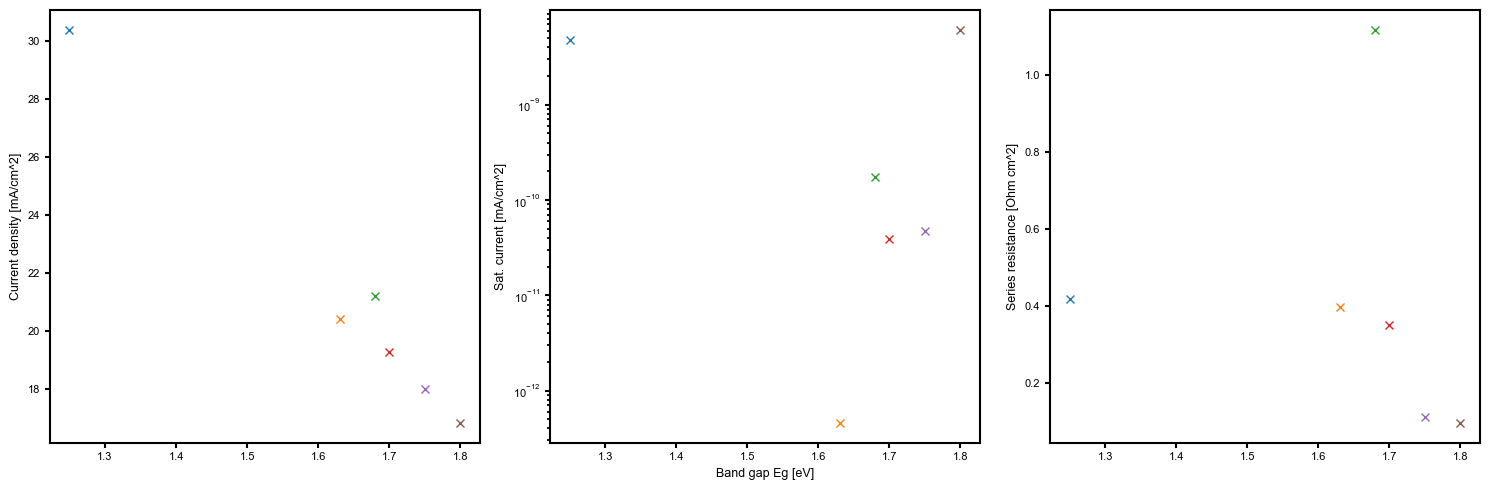

In [16]:
fig,ax = plt.subplots(1,3,sharex=True,figsize=(15, 5))
for eg in tc_eg_list:
    
    psc_params, si_params = get_jv_params(fp_psk_jv[eg], fp_si_jv, plot_fits=False)
    # (psc_isc, psc_io, psc_rs, psc_rsh, psc_nNsVth) = psc_params
    ax[0].plot(eg,psc_params[0]*1e3,"x")
    ax[1].plot(eg,psc_params[1]*1e3,"x")
    ax[2].plot(eg,psc_params[2],"x")
ax[1].set_yscale("log")

ax[1].set_xlabel("Band gap Eg [eV]")
ax[0].set_ylabel("Current density [mA/cm^2]")
ax[1].set_ylabel("Sat. current [mA/cm^2]")
ax[2].set_ylabel("Series resistance [Ohm cm^2]")
plt.tight_layout()

Assume average J0 ratio for all perovskite cells, average rs and linear fit for Jsc for PSC of varying bandgap

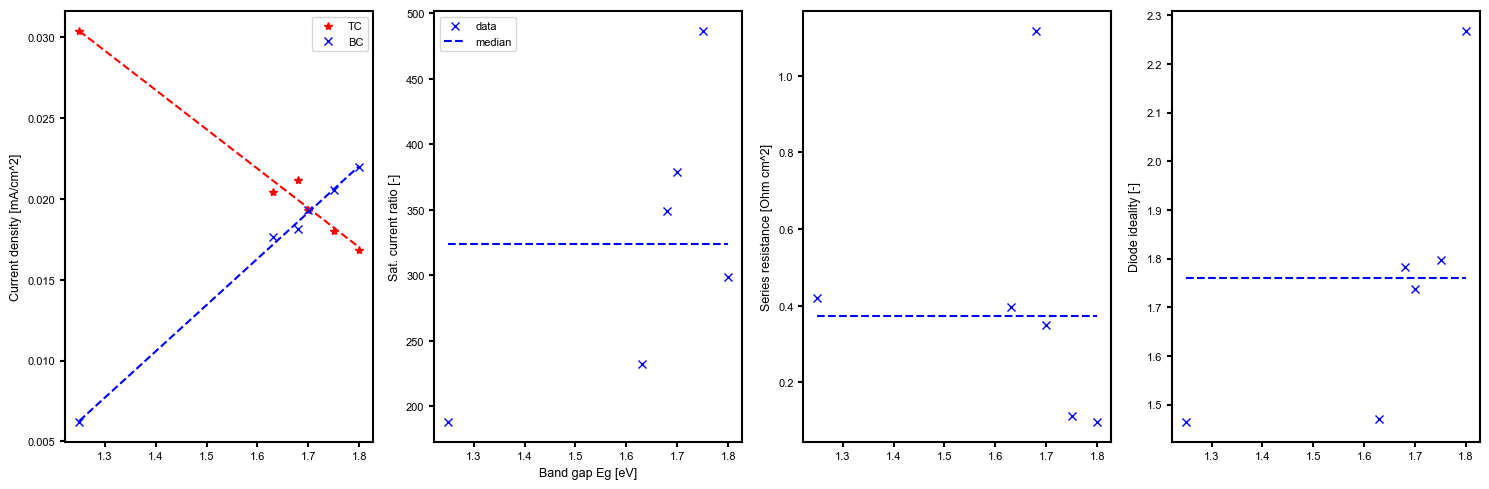

In [17]:
fig,ax = plt.subplots(1,4,sharex=True,figsize=(15, 5))

jscs_tc = []
jscs_tc_eqe = []
jscs_bc_eqe = []
j0_ratios = []
rs = []
ns = []
rsh= []

for eg in tc_eg_list:
    psc_params, si_params = get_jv_params(fp_psk_jv[eg], fp_si_jv)
    df_tandem_eqe, df_si_eqe_interp = get_tandem_eqe(fp_psk_eqe[eg], fp_psk_trans[eg], fp_si_eqe, psc_params, si_params)
    
    # df_tandem_eqe, meteo_spectra.spectra = match_eqe_spectra(df_tandem_eqe, meteo_spectra.spectra)
    df_psk_eqe_interp = df_tandem_eqe.iloc[:, 0]
    df_si_eqe_filtered = df_tandem_eqe.iloc[:, 1]   

    eg_si, sigma_si = calc_Eg_Rau(df_si_eqe_interp)
    eg_psc, sigma_psc = calc_Eg_Rau(df_psk_eqe_interp)
    

    dev3T = get_tandem_device(psc_params, si_params, df_si_eqe_filtered, eg_psc, eg_si)
    # ax[0].plot(eg,dev3T.top.Jext,"x")
    # ax[1].plot(eg,dev3T.top.J0ratio,"x")
    # ax[2].plot(eg,dev3T.top.Rser,"x")
    
    jscs_tc.append(dev3T.top.Jext)
    jscs_tc_eqe.append(integrate_eqe(df_psk_eqe_interp)[0] / 1e3)
    jscs_bc_eqe.append(integrate_eqe(df_si_eqe_filtered)[0] / 1e3)
    rs.append(dev3T.top.Rser)
    j0_ratios.append(dev3T.top.J0ratio)
    ns.append(dev3T.top.n[0])
    rsh.append(1/dev3T.top.Gsh)
    
ax[0].plot(tc_eg_list,jscs_tc,"r*")
ax[0].plot(tc_eg_list,jscs_bc_eqe,"bx")
# ax[0].plot(egs,jscs_tc_eqe,"o")
ax[1].plot(tc_eg_list,j0_ratios,"bx")
ax[2].plot(tc_eg_list,rs,"bx")
ax[3].plot(tc_eg_list,ns,"bx")

psc_jsc_fit_res = np.polyfit(tc_eg_list,jscs_tc,1)
jsc_tc_fit = np.polyval(psc_jsc_fit_res,tc_eg_list)

si_jsc_fit_res = np.polyfit(tc_eg_list,jscs_bc_eqe[:],1)
jsc_bc_fit = np.polyval(si_jsc_fit_res,tc_eg_list)

psc_mean_j0_ratio = np.median(j0_ratios)
psc_mean_rs = np.median(rs)
psc_mean_ns = np.median(ns)

si_mean_j0_ratio = np.mean(dev3T.bot.J0ratio)
si_mean_ns = dev3T.bot.n[0]
si_mean_rs= 1/dev3T.bot.Rser

ax[0].plot(tc_eg_list,jsc_tc_fit,"r--")
ax[0].plot(tc_eg_list,jsc_bc_fit,"b--")
ax[1].plot(tc_eg_list,np.ones_like(tc_eg_list) * np.median(j0_ratios),"b--")
ax[2].plot(tc_eg_list,np.ones_like(tc_eg_list) * np.median(rs),"b--")
ax[3].plot(tc_eg_list,np.ones_like(tc_eg_list) * np.median(ns),"b--")

ax[0].legend(["TC", "BC"])
ax[1].legend(["data", "median"])

ax[1].set_xlabel("Band gap Eg [eV]")
ax[0].set_ylabel("Current density [mA/cm^2]")
ax[1].set_ylabel("Sat. current ratio [-]")
ax[2].set_ylabel("Series resistance [Ohm cm^2]")
ax[3].set_ylabel("Diode ideality [-]")
plt.tight_layout()


In [18]:
eg_match = (psc_jsc_fit_res[1] - si_jsc_fit_res[1]) / (si_jsc_fit_res[0] - psc_jsc_fit_res[0])
print(eg_match)

1.7051804802861776


In [19]:
reader_settings = {"index_col": 0, "usecols": [0, 1]}

mean_topscale = []

for eg in tc_eg_list:
    psc_params, si_params = get_jv_params(fp_psk_jv[eg], fp_si_jv)    
    
    df_tandem_eqe, df_si_eqe_interp = get_tandem_eqe(fp_psk_eqe[eg], fp_psk_trans[eg], fp_si_eqe, psc_params, si_params)
    df_psk_eqe_interp = df_tandem_eqe.iloc[:, 0]
    df_si_eqe_filtered = df_tandem_eqe.iloc[:, 1]
    
    eg_calc = calc_Eg_Rau(df_psk_eqe_interp)
    lam_thres = np.round(photonenergy_to_wavelength(eg))
    
    step_eqe_bot = pd.Series(np.ones(len(df_si_eqe_interp)), index = df_si_eqe_interp.index)
    bottom_scale = si_params[0]*1e3 /integrate_eqe(step_eqe_bot)
    step_eqe_bot[step_eqe_bot.index < lam_thres] = 0    
    step_eqe_bot = step_eqe_bot * bottom_scale
    
    step_eqe_top = pd.Series(np.ones(len(df_psk_eqe_interp)), index = df_psk_eqe_interp.index)
    # top_scale = psc_params[0]*1e3 /intergrate_eqe(step_eqe_top)
    step_eqe_top[step_eqe_top.index > lam_thres] = 0    
    top_scale = integrate_eqe(df_psk_eqe_interp) /integrate_eqe(step_eqe_top)
    step_eqe_top = step_eqe_top * top_scale
    mean_topscale.append(top_scale)
    
    
    # fig,ax = plt.subplots()
    # ax.plot(df_psk_eqe_interp)
    # ax.plot(df_si_eqe_filtered)
    # ax.plot(step_eqe_top)
    # ax.plot(step_eqe_bot)
    
mean_topscale = np.max(mean_topscale)
mean_botscale = bottom_scale

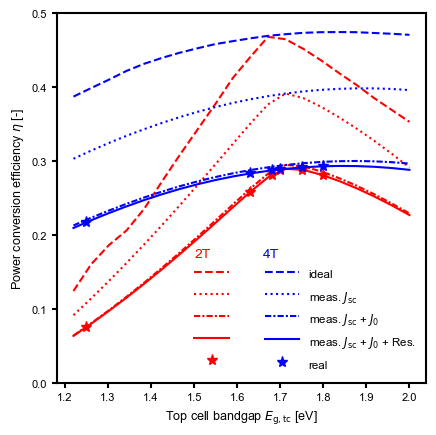

In [20]:
# [model.oper for model in meteo_location.models]
operation_modes = []

tandem_types = []
etas = []

Rz = 0


eg_si = 1.12
psc_params, si_params = get_jv_params(fp_psk_jv[1.7], fp_si_jv)


psc_egs = np.linspace(eg_si + 0.1,2,20)

eta_ideal = pd.DataFrame(np.zeros([len(psc_egs), 4]), index = psc_egs, columns = ["4T", "2T", "s-3T", "r-3T"])
eta_norecombination = pd.DataFrame(np.zeros([len(psc_egs), 4]), index = psc_egs, columns = ["4T", "2T", "s-3T", "r-3T"])
eta_nors = pd.DataFrame(np.zeros([len(psc_egs), 4]), index = psc_egs, columns = ["4T", "2T", "s-3T", "r-3T"])
eta_rs = pd.DataFrame(np.zeros([len(psc_egs), 4]), index = psc_egs, columns = ["4T", "2T", "s-3T", "r-3T"])


for eg_psc in psc_egs:
    
    lam_thres = np.round(photonenergy_to_wavelength(eg_psc))
    lam = np.arange(300,1200,1)
    step_eqe_bot = pd.Series(np.ones(len(lam)), index = lam)
    step_eqe_bot[step_eqe_bot.index < lam_thres] = 0    
    # step_eqe_bot = step_eqe_bot * mean_botscale
    step_eqe_bot = step_eqe_bot * 1
    
    step_eqe_top = pd.Series(np.ones(len(lam)), index = lam)
    step_eqe_top[step_eqe_top.index > lam_thres] = 0    
    # step_eqe_top = step_eqe_top * mean_topscale
    step_eqe_top = step_eqe_top * 1
    
    jext_top = integrate_eqe(step_eqe_top)
    jext_bot = integrate_eqe(step_eqe_bot)
    
    # lam_top = np.arange(300,lam_thres,1)
    # lam_bot = np.arange(lam_thres,photonenergy_to_wavelength(eg_si))
    
    # eqe_top = pvc.EQE(np.ones(lam_top.shape)*mean_topscale, lam_top, "Psk")  # EQE class
    # eqe_bot = pvc.EQE(np.ones(lam_bot.shape)*mean_botscale, lam_bot, "Si")  # EQE class
    # jext_top = eqe_top.Jint()
    # jext_bot = eqe_bot.Jint()
    
    dev3T = pvc.Tandem3T()
    
    dev3T.top.set(Rser=Rz)
    dev3T.set(Rz=Rz)
    # dev2T = pvc.Multi2T.from_3T(dev3T)
    
    dev3T.top.set(Jext = jext_top / 1e3, n = [1], J0ratio = [1], Rser = 0, Gsh = 0, JLC = 0, Eg = eg_psc, beta = 0)
    dev3T.bot.set(Jext = jext_bot / 1e3, n = [1], J0ratio = [1], Rser = 0, Gsh = 0, JLC = 0, Eg = eg_si, beta = 0)
    
    dev3T.bot.set(pn=1)  # s-type
    
    iv3t = dev3T.MPP()
    eta_ideal["4T"].loc[eg_psc] = iv3t.Ptot[0] * 10

    _, iv3t = dev3T.CM()
    eta_ideal["2T"].loc[eg_psc] = iv3t.Ptot[0] * 10
    
    _, iv3t = dev3T.VM(2,1)
    eta_ideal["s-3T"].loc[eg_psc] = iv3t.Ptot[0] * 10
    
    dev3T.bot.set(pn=-1)  # r-type
    _, iv3t = dev3T.VM(2,1)
    eta_ideal["r-3T"].loc[eg_psc] = iv3t.Ptot[0] * 10
    
    
    jext_top = np.polyval(psc_jsc_fit_res,eg_psc)
    jext_bot = np.polyval(si_jsc_fit_res,eg_psc)
    
    dev3T.top.set(Jext = jext_top, n = [psc_mean_ns], J0ratio = [1], Rser = 0, Gsh = 0, JLC = 0, Eg = eg_psc, beta = 0)
    dev3T.bot.set(Jext = jext_bot, n = [si_mean_ns], J0ratio = [1], Rser = 0, Gsh = 0, JLC = 0, Eg = eg_si, beta = 0)
    
    dev3T.bot.set(pn=1)  # s-type
    
    iv3t = dev3T.MPP()
    eta_norecombination["4T"].loc[eg_psc] = iv3t.Ptot[0] * 10

    _, iv3t = dev3T.CM()
    eta_norecombination["2T"].loc[eg_psc] = iv3t.Ptot[0] * 10
    
    _, iv3t = dev3T.VM(2,1)
    eta_norecombination["s-3T"].loc[eg_psc] = iv3t.Ptot[0] * 10
    
    dev3T.bot.set(pn=-1)  # r-type
    _, iv3t = dev3T.VM(2,1)
    eta_norecombination["r-3T"].loc[eg_psc] = iv3t.Ptot[0] * 10
    
    jext_top = np.polyval(psc_jsc_fit_res,eg_psc)
    jext_bot = np.polyval(si_jsc_fit_res,eg_psc)
    dev3T.top.set(Jext = jext_top, n = [psc_mean_ns], J0ratio = [psc_mean_j0_ratio], Rser = 0, Gsh = 0, JLC = 0, Eg = eg_psc, beta = 0)
    dev3T.bot.set(Jext = jext_bot, n = [si_mean_ns], J0ratio = [si_mean_j0_ratio], Rser = 0, Gsh = 0, JLC = 0, Eg = eg_si, beta = 0)
    
    dev3T.bot.set(pn=1)  # s-type
    
    iv3t = dev3T.MPP()
    eta_nors["4T"].loc[eg_psc] = iv3t.Ptot[0] * 10

    _, iv3t = dev3T.CM()
    eta_nors["2T"].loc[eg_psc] = iv3t.Ptot[0] * 10
    
    _, iv3t = dev3T.VM(2,1)
    eta_nors["s-3T"].loc[eg_psc] = iv3t.Ptot[0] * 10
    
    dev3T.bot.set(pn=-1)  # r-type
    _, iv3t = dev3T.VM(2,1)
    eta_nors["r-3T"].loc[eg_psc] = iv3t.Ptot[0] * 10
    
    jext_top = np.polyval(psc_jsc_fit_res,eg_psc)
    jext_bot = np.polyval(si_jsc_fit_res,eg_psc)
    dev3T.top.set(Jext = jext_top, n = [psc_mean_ns], J0ratio = [psc_mean_j0_ratio], Rser = psc_mean_rs, Gsh = 0, JLC = 0, Eg = eg_psc, beta = 0)
    dev3T.bot.set(Jext = jext_bot, n = [si_mean_ns], J0ratio = [si_mean_j0_ratio], Rser = si_mean_rs, Gsh = 0, JLC = 0, Eg = eg_si, beta = 0)

    dev3T.bot.set(pn=1)  # s-type
    
    iv3t = dev3T.MPP()
    eta_rs["4T"].loc[eg_psc] = iv3t.Ptot[0] * 10

    _, iv3t = dev3T.CM()
    eta_rs["2T"].loc[eg_psc] = iv3t.Ptot[0] * 10
    
    _, iv3t = dev3T.VM(2,1)
    eta_rs["s-3T"].loc[eg_psc] = iv3t.Ptot[0] * 10
    
    dev3T.bot.set(pn=-1)  # r-type
    _, iv3t = dev3T.VM(2,1)
    eta_rs["r-3T"].loc[eg_psc] = iv3t.Ptot[0] * 10



eta_real = pd.DataFrame(np.zeros([len(tc_eg_list), 4]), index = tc_eg_list, columns = ["4T", "2T", "s-3T", "r-3T"])


for eg_psc in tc_eg_list:
    
    lam_thres = np.round(photonenergy_to_wavelength(eg_psc))
    
    lam_top = np.arange(300,lam_thres,1)
    lam_bot = np.arange(lam_thres,photonenergy_to_wavelength(eg_si))
    
    eqe_bot = pvc.EQE(np.ones(lam_bot.shape), lam_bot, "Si")  # EQE class
    jext_bot = eqe_bot.Jint()
    eqe_bot = pvc.EQE(np.ones(lam_bot.shape), lam_bot, "Si")  # EQE class
    jext_bot = eqe_bot.Jint()
    
    # use linear fit and average values for diode parameters
    jext_top = np.polyval(psc_jsc_fit_res,eg_psc)
    jext_bot = np.polyval(si_jsc_fit_res,eg_psc)
    dev3T.top.set(Jext = jext_top, n = [psc_mean_ns], J0ratio = [psc_mean_j0_ratio], Rser = psc_mean_rs, Gsh = 0, JLC = 0, Eg = eg_psc, beta = 0)
    dev3T.bot.set(Jext = jext_bot, n = [si_mean_ns], J0ratio = [si_mean_j0_ratio], Rser = si_mean_rs, Gsh = 0, JLC = 0, Eg = eg_si, beta = 0)
    
    # use indiviual fit parameters
    psc_params, si_params = get_jv_params(fp_psk_jv[eg_psc], fp_si_jv)
    df_tandem_eqe, df_si_eqe_interp = get_tandem_eqe(fp_psk_eqe[eg_psc], fp_psk_trans[eg_psc], fp_si_eqe, psc_params, si_params)
    # df_tandem_eqe, meteo_spectra_filtered.spectra = match_eqe_spectra(df_tandem_eqe, meteo_spectra_filtered.spectra)
    df_psk_eqe_interp = df_tandem_eqe.iloc[:, 0]
    df_si_eqe_filtered = df_tandem_eqe.iloc[:, 1]

    eg_bc, sigma_si = calc_Eg_Rau(df_si_eqe_interp)
    eg_tc, sigma_psc = calc_Eg_Rau(df_psk_eqe_interp)

    # dev3T = get_tandem_device(psc_params, si_params, df_si_eqe_filtered, eg_tc, eg_bc)
    
    dev3T.bot.set(pn=1)  # s-type
    
    iv3t = dev3T.MPP()
    eta_real["4T"].loc[eg_psc] = iv3t.Ptot[0] * 10

    _, iv3t = dev3T.CM()
    eta_real["2T"].loc[eg_psc] = iv3t.Ptot[0] * 10
    
    _, iv3t = dev3T.VM(2,1)
    eta_real["s-3T"].loc[eg_psc] = iv3t.Ptot[0] * 10
    
    dev3T.bot.set(pn=-1)  # r-type
    _, iv3t = dev3T.VM(2,1)
    eta_real["r-3T"].loc[eg_psc] = iv3t.Ptot[0] * 10
   


plt.rcParams["lines.markersize"] = 8
fig, ax = plt.subplots(1)
ax.plot(eta_ideal[["2T"]], "r--", label=" ")
ax.plot(eta_norecombination[["2T"]],"r:", label=" ")
ax.plot(eta_nors[["2T"]],"r", linestyle=(0, (3, 1, 1, 1)), label=" ")
ax.plot(eta_rs[["2T"]], "r-", label=" ")
ax.plot(eta_real[["2T"]], "r*", label=" ")

ax.plot(eta_ideal[["4T"]], "b--", label="ideal")
ax.plot(eta_norecombination[["4T"]],"b:", label="meas. $J_\mathrm{sc}$")
ax.plot(eta_nors[["4T"]],"b", linestyle=(0, (3, 1, 1, 1)), label="meas. $J_\mathrm{sc}$ + $J_\mathrm{0}$")
ax.plot(eta_rs[["4T"]], "b-", label="meas. $J_\mathrm{sc}$ + $J_\mathrm{0}$ + Res.")
ax.plot(eta_real[["4T"]], "b*", label="real")

leg = ax.legend(ncol=2,loc='lower right', frameon=False, fontsize='small', handlelength=3, handleheight=1.8)
plt.draw()
# p = leg.get_position()

ax.annotate('2T', (1.5, 0.17), 
            xycoords='data', color="r")
ax.annotate('4T', (1.66, 0.17), 
            xycoords='data', color="b")

ax.set_xlabel("Top cell bandgap $E_\mathrm{g,tc}$ [eV]")
ax.set_ylabel("Power conversion efficiency $\\eta$ [-]")
ax.set_ylim(0,0.5)
ax.set_box_aspect(1)


# dev3T = pvc.Tandem3T()
# eg_psc = 1.7
# dev3T.top.set(Rser=0)
# dev3T.set(Rz=0)

# jext_top = np.polyval(psc_jsc_fit_res,eg_psc)
# jext_bot = np.polyval(si_jsc_fit_res,eg_psc)

# dev3T.top.set(Jext = jext_top, n = [psc_mean_ns], J0ratio = psc_mean_j0_ratio, Rser = psc_mean_rs, Gsh = 0, JLC = 0, Eg = eg_psc, beta = 0)
# dev3T.bot.set(Jext = jext_bot, n = [si_mean_ns], J0ratio = si_mean_j0_ratio, Rser = si_mean_rs, Gsh = 0, JLC = 0, Eg = eg_si, beta = 0)
# iv3t = dev3T.MPP()
# ax.plot(eg_psc, iv3t.Ptot[0] * 10, "g*")

# _, iv3t = dev3T.CM()
# ax.plot(eg_psc, iv3t.Ptot[0] * 10, "g*")


Current matched tandem

In [21]:
# print(f"psc_j0_ratio  = {psc_mean_j0_ratio:.0f}")
# print(f"psc_mean_rs = {psc_mean_rs:.1f}")
# print(f"psc_mean_ns = {psc_mean_ns:.1f}")

# print(f"si_mean_j0_ratio = {si_mean_j0_ratio[0]:.0f}")
# print(f"si_mean_ns = {si_mean_ns:.1f}")
# print(f"si_mean_rs = {si_mean_rs:.1f}")

mean_dev3T = pvc.Tandem3T()
eg_psc = 1.7
mean_dev3T.top.set(Rser=0)
mean_dev3T.set(Rz=0)

jext_top = np.polyval(psc_jsc_fit_res,eg_psc)
jext_bot = np.polyval(si_jsc_fit_res,eg_psc)

mean_dev3T.top.set(Jext = jext_top, n = [psc_mean_ns], J0ratio = [psc_mean_j0_ratio], Rser = psc_mean_rs, Gsh = 0, JLC = 0, Eg = eg_psc, beta = 0)
mean_dev3T.bot.set(Jext = jext_bot, n = [si_mean_ns], J0ratio = [si_mean_j0_ratio], Rser = si_mean_rs, Gsh = 0, JLC = 0, Eg = eg_si, beta = 0)
mean_dev3T

Tandem3T: <pvcircuit.tandem3T.Tandem3T class>
T = 25.0 C, Rz= 0 Ω cm2, Rt= 0.373758 Ω cm2, Rr = 1.18613 Ω cm2

top: <pvcircuit.junction.Junction class>
Eg = 1.70 eV, TC = 25.0 C
Jext = 19.4 mA/cm2, JLC = 0.0 mA/cm2
Gsh = 0 S/cm2, Rser = 0.373758 Ωcm2
lightA = 1 cm2, totalA = 1 cm2
pn = -1, beta = 0, gamma = 0
   n    J0ratio   J0(A/cm2) 
  db       1      2.226e-26 
 1.76    323.90   4.406e-14 

bot: <pvcircuit.junction.Junction class>
Eg = 1.12 eV, TC = 25.0 C
Jext = 19.2 mA/cm2, JLC = 0.0 mA/cm2
Gsh = 0 S/cm2, Rser = 1.18613 Ωcm2
lightA = 1 cm2, totalA = 1 cm2
pn = 1, beta = 0, gamma = 0
   n    J0ratio   J0(A/cm2) 
  db       1      6.250e-17 
 1.38   1594.37   4.262e-10 

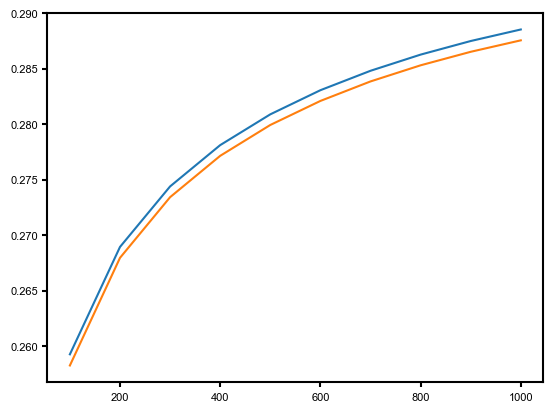

In [22]:
irradiance_set = np.linspace(100,1000,10)
p2T = []
p4T = []
for irradiance in irradiance_set:
    jext_top_scale = jext_top * irradiance / 1000
    jext_bot_scale = jext_bot * irradiance / 1000

    mean_dev3T.top.set(Jext = jext_top_scale)
    mean_dev3T.bot.set(Jext = jext_bot_scale)
    
    iv3t = mean_dev3T.MPP()
    p4T.append(iv3t.Ptot[0] / irradiance *1e4)

    _, iv3t = mean_dev3T.CM()
    p2T.append(iv3t.Ptot[0] / irradiance *1e4)
fig, ax = plt.subplots()
ax.plot(irradiance_set, p4T)
ax.plot(irradiance_set, p2T)

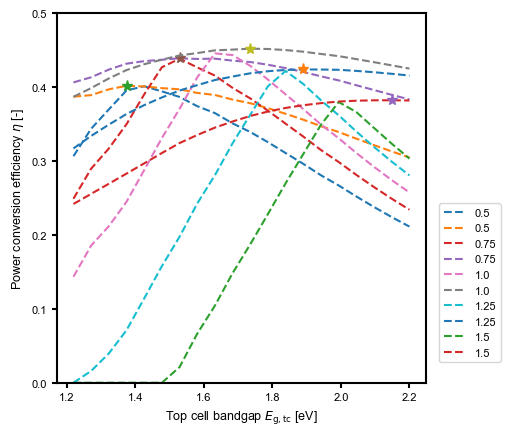

In [23]:
# [model.oper for model in meteo_location.models]
operation_modes = []

tandem_types = []
etas = []

Rz = 0


eg_si = 1.12
psc_params, si_params = get_jv_params(fp_psk_jv[1.7], fp_si_jv)


psc_egs = np.linspace(eg_si + 0.1,2.2,20)

eta_ideal = pd.DataFrame(np.zeros([len(psc_egs), 4]), index = psc_egs, columns = ["4T", "2T", "s-3T", "r-3T"])

fig,ax = plt.subplots()

# for curr_factor in np.linspace(1,10,4):
for eg_bot in np.linspace(0.5,1.5,5):
    for eg_top in psc_egs:
        
        lam_thres = np.round(photonenergy_to_wavelength(eg_top))
        lam = np.arange(350,np.round(photonenergy_to_wavelength(eg_bot)),1)
        step_eqe_bot = pd.Series(np.ones(len(lam)), index = lam)
        step_eqe_bot[step_eqe_bot.index < lam_thres] = 0
        # step_eqe_bot = step_eqe_bot * curr_factor
        
        step_eqe_top = pd.Series(np.ones(len(lam)), index = lam)
        step_eqe_top[step_eqe_top.index > lam_thres] = 0    
        # step_eqe_top = step_eqe_top * curr_factor
        
        jext_top = integrate_eqe(step_eqe_top)
        jext_bot = integrate_eqe(step_eqe_bot)
        
        dev3T = pvc.Tandem3T()
        
        dev3T.top.set(Rser=Rz)
        dev3T.set(Rz=Rz)
        # dev2T = pvc.Multi2T.from_3T(dev3T)
        
        dev3T.top.set(Jext = jext_top / 1e3, n = [1], J0ratio = [1], Rser = 0, Gsh = 0, JLC = 0, Eg = eg_top, beta = 0)
        dev3T.bot.set(Jext = jext_bot / 1e3, n = [1], J0ratio = [1], Rser = 0, Gsh = 0, JLC = 0, Eg = eg_bot, beta = 0)
        
        dev3T.bot.set(pn=1)  # s-type
        
        iv3t = dev3T.MPP()
        eta_ideal["4T"].loc[eg_top] = iv3t.Ptot[0] * 10

        _, iv3t = dev3T.CM()
        eta_ideal["2T"].loc[eg_top] = iv3t.Ptot[0] * 10
        
        _, iv3t = dev3T.VM(2,1)
        eta_ideal["s-3T"].loc[eg_top] = iv3t.Ptot[0] * 10
        
        dev3T.bot.set(pn=-1)  # r-type
        _, iv3t = dev3T.VM(2,1)
        eta_ideal["r-3T"].loc[eg_top] = iv3t.Ptot[0] * 10
        
        
    ax.plot(eta_ideal[["2T"]], "--", label=eg_bot)
    ax.plot(eta_ideal[["4T"]], "--", label=eg_bot)
    ax.plot(eta_ideal["4T"].idxmax(),eta_ideal["4T"].max(), "*")

leg = ax.legend(bbox_to_anchor = (1.02,0.5))

ax.set_xlabel("Top cell bandgap $E_\mathrm{g,tc}$ [eV]")
ax.set_ylabel("Power conversion efficiency $\\eta$ [-]")
ax.set_ylim(0,0.5)
ax.set_box_aspect(1)

# Load meteorological data <b>
 
currently uses pickle for faster reloading

In [24]:
date_start = datetime(2021, 11, 1, 0, 0, 0)
date_end = datetime(2022, 11, 1, 0, 0, 0) - pd.Timedelta(seconds=1)

# meteo_spectra = get_meteo(date_start, date_end, "1T")

# with open("meteo_year.p", "wb") as fout:
#     pickle.dump(meteo_spectra,fout)
    
## Load global meteorological data from 01.11.2021 until 31.10.2022
with open(r"meteo_data/meteo_year.p", "rb") as fin:
    meteo_spectra = pickle.load(fin)

## Load direct meteorological data from 01.11.2021 until 31.10.2022
# with open("direct_meteo_year.p", "rb") as fin:
#     meteo_spectra = pickle.load(fin)



Get environmental irradiance data

In [25]:
# meteo_data = Meteorological.get_midc_environmental(date_start, date_end)

# with open("meteo_data_ehe.p", "wb") as fout:
#     pickle.dump(meteo_data,fout)

with open(r"meteo_data/meteo_data_ehe.p", "rb") as fin:
    meteo_data = pickle.load(fin)


Filter spectral data by irradiance sensor data

Determine average photon energy (APE) and Filter irrelevant energies


In [26]:
meteo_spectra.calc_ape()

# _, meteo_data_sync = sync(meteo_spectra.spectra, meteo_data.data)
# dir_diff_ratio = meteo_data_sync["Direct CHP1-1 [W/m^2]"] / meteo_data_sync["Diffuse CM22-1 (vent/cor) [W/m^2]"]
# meteo_spectra_filtered = meteo_spectra.filter_ape(min_ape = 1, max_ape = 2.2).filter_spectra(min_spectra = 0)
# meteo_spectra_filtered = meteo_spectra.filter_ape(min_ape = 1, max_ape = 2.2).filter_spectra(min_spectra = 0)
meteo_spectra_filtered = meteo_spectra.filter_ape(min_ape=0, max_ape=4)
neg_spectra_filter = meteo_spectra_filtered.spectra < -1e-2
neg_spectra_filter = (neg_spectra_filter.sum(axis=1) / meteo_spectra_filtered.spectra.shape[1]) > 0.01
meteo_spectra_filtered = meteo_spectra_filtered.filter_custom(~neg_spectra_filter)
_, meteo_data_sync = sync(meteo_spectra_filtered.spectra, meteo_data.data)
dir_diff_ratio = meteo_data_sync["Direct CHP1-1 [W/m^2]"] / meteo_data_sync["Diffuse CM22-1 (vent/cor) [W/m^2]"]
meteo_spectra_filtered = meteo_spectra_filtered.filter_custom(dir_diff_ratio > 0)


In [27]:
_, meteo_data_sync = sync(meteo_spectra_filtered.spectra,meteo_data.data)

APE vs minute of day

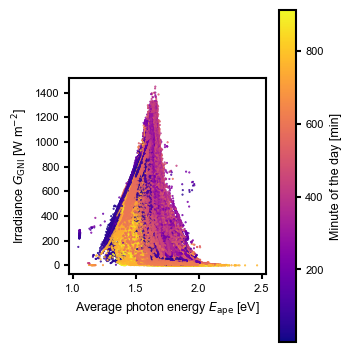

In [28]:
# Set location (latitude, longitude, and timezone) to Golden, CO
location = pvlib.location.Location(39.7555, -105.2211, 'America/Denver')

# Get sunrise and sunset times
sunrise_sunset = location.get_sun_rise_set_transit(meteo_spectra_filtered.spectra.index.tz_localize(location.tz), method='spa')

fig, ax = plt.subplots(1, constrained_layout = True, figsize=fig_onecol)

label = "Minute of the day [min]"

minod_filter = (meteo_spectra_filtered.spectra.index.tz_localize(location.tz) >= sunrise_sunset["sunrise"]) & (meteo_spectra_filtered.spectra.index.tz_localize(location.tz) >= sunrise_sunset["sunrise"])
minod = (meteo_spectra_filtered.spectra.index.hour * 60 + meteo_spectra_filtered.spectra.index.minute) - (sunrise_sunset["sunrise"].dt.hour * 60 - sunrise_sunset["sunrise"].dt.minute)

sp = ax.scatter(
    meteo_spectra_filtered.average_photon_energy[minod_filter], meteo_spectra_filtered.SpecPower[minod_filter], [1], minod[minod_filter], marker=".", cmap="plasma"
)

fig.colorbar(sp,ax = ax, label = label)

ax.set_xlabel("Average photon energy $E_\mathrm{ape}$ [eV]")
ax.set_ylabel("Irradiance $G_{\mathrm{GNI}}$ [W m$^{-2}$]")
ax.set_box_aspect(1)


C:\Users\rwitteck\AppData\Local\Temp\1\ipykernel_22812\2338904446.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticks(), rotation=45, ha='right')  # Rotates X-Axis Ticks by 45-degrees


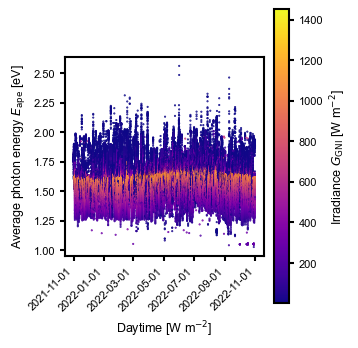

In [29]:
fig, ax = plt.subplots(1, constrained_layout = True, figsize=fig_onecol)

label = "Irradiance $G_{\mathrm{GNI}}$ [W m$^{-2}$]"

# sp = ax.scatter(
#     meteo_spectra_filtered.average_photon_energy, meteo_spectra_filtered.SpecPower, None, month_year, marker=".", cmap="plasma"
# )
sp = ax.scatter(
    meteo_spectra_filtered.spectra.index,
    meteo_spectra_filtered.average_photon_energy,
    [1],
    meteo_spectra_filtered.SpecPower,
    marker=".",
    cmap="plasma",
)

fig.colorbar(sp, ax=ax, label=label)

ax.set_xlabel("Daytime [W m$^{-2}$]")
ax.set_xticklabels(ax.get_xticks(), rotation=45, ha='right')  # Rotates X-Axis Ticks by 45-degrees
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

ax.set_ylabel("Average photon energy $E_\mathrm{ape}$ [eV]")
ax.set_box_aspect(1)

APE vs diffuse/direct ratio

Text(0, 0.5, 'Irradiance $G_{\\mathrm{GNI}}$ [W m$^{-2}$]')

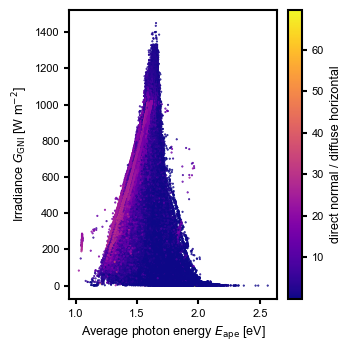

In [30]:
fig, ax = plt.subplots(1, constrained_layout = True, figsize=fig_onecol)

label = "direct normal / diffuse horizontal"
dir_diff_ratio = meteo_data_sync["Direct CHP1-1 [W/m^2]"] / meteo_data_sync["Diffuse CM22-1 (vent/cor) [W/m^2]"]

# label = "direct normal / global horizontal"
# dir_diff_ratio = meteo_data_sync["Direct CHP1-1 [W/m^2]"] / meteo_data_sync["Global CMP22 (vent/cor) [W/m^2]"]

# label = "diffuse horizontal / global horizontal"
# dir_diff_ratio = meteo_data_sync["Diffuse CM22-1 (vent/cor) [W/m^2]"] / meteo_data_sync["Global CMP22 (vent/cor) [W/m^2]"]

# label = "direct normal / global normal"
# dir_diff_ratio = meteo_data_sync["Direct CHP1-1 [W/m^2]"] / meteo_data_sync["Global Normal CMP22 [W/m^2]"]

# label = "diffuse horizontal / global normal"
# dir_diff_ratio = meteo_data_sync["Diffuse CM22-1 (vent/cor) [W/m^2]"] / meteo_data_sync["Global Normal CMP22 [W/m^2]"]

# label = "direct horizontal / diffuse horizontal"
# dir_diff_ratio = (meteo_data_sync["Global CMP22 (vent/cor) [W/m^2]"] - meteo_data_sync["Diffuse CM22-1 (vent/cor) [W/m^2]"]) / meteo_data_sync["Diffuse CM22-1 (vent/cor) [W/m^2]"]

sp = ax.scatter(
    meteo_spectra_filtered.average_photon_energy, meteo_spectra_filtered.SpecPower, 1, dir_diff_ratio, marker=".", cmap="plasma"
)

# sp = ax.scatter(
#     meteo_spectra_filtered.average_photon_energy, meteo_data_sync["Global Normal CMP22 [W/m^2]"], [1], dir_diff_ratio, marker=".", cmap="plasma"
# )
fig.colorbar(sp,ax = ax, label = label)

ax.set_xlabel("Average photon energy $E_\mathrm{ape}$ [eV]")
ax.set_ylabel("Irradiance $G_{\mathrm{GNI}}$ [W m$^{-2}$]")

Text(0, 0.5, 'Irradiance $G_{\\mathrm{GNI}}$ [W m$^{-2}$]')

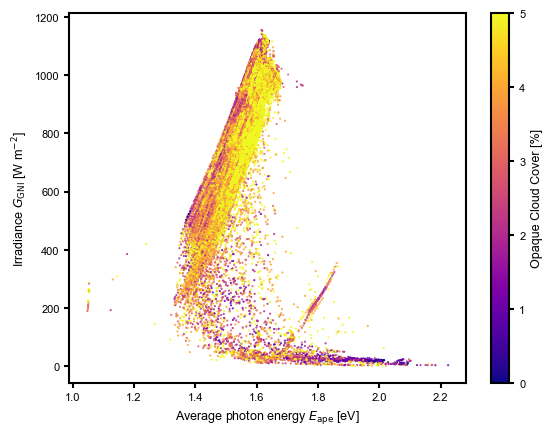

In [31]:
fig, ax = plt.subplots(1)

label = "Total Cloud Cover [%]"
label = "Opaque Cloud Cover [%]"
# label = "Airmass"
# label = "Albedo (CMP11)"
# label = "Deck RH [%]"

plot_filter = (meteo_data_sync[label] <= 5) & (meteo_data_sync[label] >= 0)
# plot_filter = np.ones_like(meteo_data_sync[label],dtype=bool)
color_data = meteo_data_sync[label]


sp = ax.scatter(
    meteo_spectra_filtered.average_photon_energy[plot_filter], meteo_spectra_filtered.SpecPower[plot_filter], 1, color_data[plot_filter], marker=".", cmap="plasma"
)
fig.colorbar(sp,ax = ax, label = label)

ax.set_xlabel("Average photon energy $E_\mathrm{ape}$ [eV]")
ax.set_ylabel("Irradiance $G_{\mathrm{GNI}}$ [W m$^{-2}$]")

Integrate currrents from spectra and EQE

In [32]:
currents = pd.DataFrame(
    np.zeros([meteo_spectra_filtered.spectra.shape[0], len(tc_eg_list) * 2]),
    index=meteo_spectra_filtered.spectra.index,
    columns=[
        f"{jsc}_{eg}"
        for jsc, eg in zip(
            ["Jsctop", "Jscbot"] * len(tc_eg_list), [eg for eg in tc_eg_list for _ in range(2)]
        )
    ],
)

for idx, eg in enumerate(tc_eg_list):

    psc_params, si_params = get_jv_params(fp_psk_jv[eg], fp_si_jv)
    df_tandem_eqe, df_si_eqe_interp = get_tandem_eqe(fp_psk_eqe[eg], fp_psk_trans[eg], fp_si_eqe, psc_params, si_params)
    # df_tandem_eqe, meteo_spectra_filtered.spectra = match_eqe_spectra(df_tandem_eqe, meteo_spectra_filtered.spectra)
    df_psk_eqe_interp = df_tandem_eqe.iloc[:, 0]
    df_si_eqe_filtered = df_tandem_eqe.iloc[:, 1]

    # dev3T.top.set(Rser=Rz)

    # spectra = wiser_global_horizontal.spectra.loc[date_plot]
    spectra_T = meteo_spectra_filtered.spectra.T
    spectra_T.index = meteo_spectra_filtered.wavelength

    spectra_interp = spectra_T.reindex(index=df_psk_eqe_interp.index).interpolate(method="index")

    # spectra = wiser_global_horizontal.spectra.loc[date_start:date_end].T
    Jsc_top = np.trapz(
        constants.e
        / constants.h
        / constants.c
        * spectra_interp.index.values.reshape(-1, 1)
        * spectra_interp.values
        * df_psk_eqe_interp.values.reshape(-1, 1)
        * 1e-10,
        x=spectra_interp.index,
        axis=0,
    )
    Jsc_bottom = np.trapz(
        constants.e / constants.h / constants.c * spectra_interp.index.values.reshape(-1, 1) * spectra_interp.values
        # * df_si_eqe_interp.values
        * df_si_eqe_filtered.values.reshape(-1, 1) * 1e-10,
        x=spectra_interp.index,
        axis=0,
    )

    currents.iloc[:, 2 * idx] = Jsc_top
    currents.iloc[:, 2 * idx + 1] = Jsc_bottom

Text(0, 0.5, 'Top cell current $J_\\mathrm{sc,top}$ [mA cm$^{-2}$]')

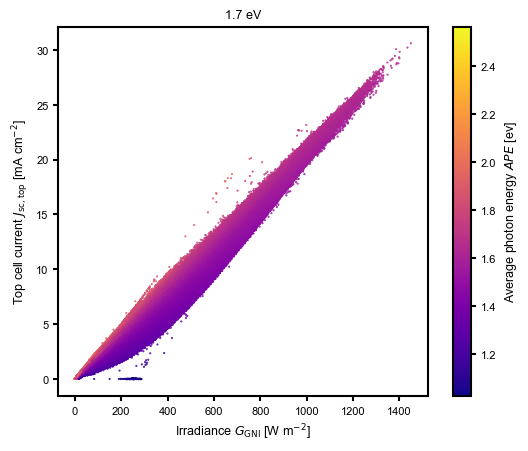

In [33]:
fig, ax = plt.subplots(1)

idx_plot = 3
sp = ax.scatter(
    meteo_spectra_filtered.SpecPower, currents.iloc[:, 2 * idx_plot], 1, meteo_spectra_filtered.average_photon_energy, marker = '.', cmap = "plasma",
    # vmin= 0.5,
    # vmax = 2
)
# sp = ax.scatter(
#     meteo_spectra_filtered.SpecPower, currents.iloc[:, 2 * idx_plot + 1], 1, meteo_spectra_filtered.average_photon_energy, marker = '.', cmap = "plasma",
#     # vmin= 0.5,
#     # vmax = 2
# )
plt.colorbar(sp, ax=ax, orientation="vertical", label="Average photon energy $APE$ [ev]")

# limits
ax.set_box_aspect(1)
ax.set_title(f"{tc_eg_list[idx_plot]} eV")
ax.set_xlabel("Irradiance $G_{\mathrm{GNI}}$ [W m$^{-2}$]")
ax.set_ylabel("Top cell current $J_\mathrm{sc,top}$ [mA cm$^{-2}$]")


Text(0, 0.5, 'Top cell current $J_\\mathrm{sc,top}$ [mA cm$^{-2}$]')

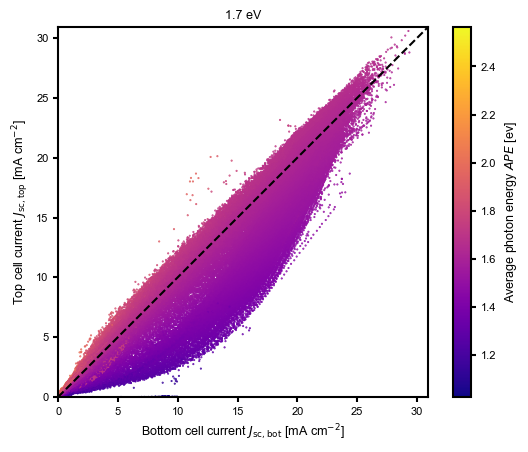

In [34]:
fig, ax = plt.subplots(1)

idx_plot = 3
sp = ax.scatter(
    currents.iloc[:, 2 * idx_plot + 1], currents.iloc[:, 2 * idx_plot], 1, meteo_spectra_filtered.average_photon_energy, marker = '.', cmap = "plasma",
    # vmin= 0.5,
    # vmax = 2
)
# plt.colorbar(sp, ax=ax, orientation="vertical", label="Energy harvesting efficiency $EHE$ [-]")
# plt.colorbar(sp, ax=ax, orientation="vertical", label="Minute of the day [min]")
plt.colorbar(sp, ax=ax, orientation="vertical", label="Average photon energy $APE$ [ev]")

max_current = max([currents.iloc[:, 2 * idx_plot + 1].max(), currents.iloc[:, 2 * idx_plot].max()]) * 1.01
ax.plot([0, max_current], [0, max_current], "k--")

# limits
ax.set_xlim(0, max_current)
ax.set_ylim(0, max_current)
ax.set_box_aspect(1)

ax.set_title(f"{tc_eg_list[idx_plot]} eV")
ax.set_xlabel("Bottom cell current $J_\mathrm{sc,bot}$ [mA cm$^{-2}$]")
ax.set_ylabel("Top cell current $J_\mathrm{sc,top}$ [mA cm$^{-2}$]")


Text(0, 0.5, 'Top cell current $J_\\mathrm{sc,top}$ [mA cm$^{-2}$]')

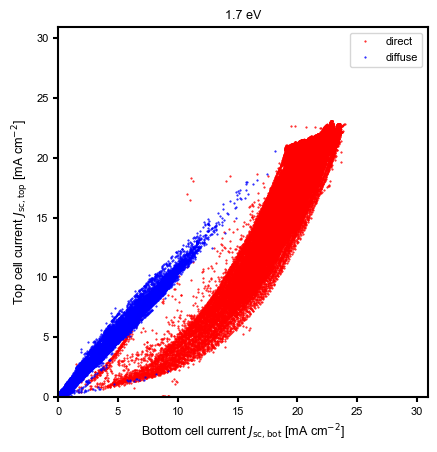

In [35]:
label = "direct normal / diffuse horizontal"
dir_diff_ratio = meteo_data_sync["Direct CHP1-1 [W/m^2]"] / meteo_data_sync["Diffuse CM22-1 (vent/cor) [W/m^2]"]
# dir_diff_ratio = _normalize(dir_diff_ratio)


# direct fraction
dir_diff_threshold = dir_diff_ratio.quantile(0.75) # upper 20 % which are direct
# dir_diff_threshold = 0.7

currents_filterd = currents[dir_diff_ratio > dir_diff_threshold]
ape_filtered = meteo_spectra_filtered.average_photon_energy[dir_diff_ratio > dir_diff_threshold]

fig, ax = plt.subplots(1)
ax.plot(currents_filterd.iloc[:, 2 * idx_plot+1], currents_filterd.iloc[:, 2 * idx_plot], "r.", ms=1)  # None, ape_filtered, marker = '.', cmap = "plasma"

# diffuse fraction
dir_diff_threshold = dir_diff_ratio.quantile(0.25)  # lower 20 % which are diffuse
# dir_diff_threshold = 0.2

currents_filterd = currents[dir_diff_ratio < dir_diff_threshold]
ape_filtered = meteo_spectra_filtered.average_photon_energy[dir_diff_ratio < dir_diff_threshold]

ax.plot(currents_filterd.iloc[:, 2 * idx_plot+1], currents_filterd.iloc[:, 2 * idx_plot], "b.", ms=1)

# sp = ax.scatter(
#     fy_data_filterd["topcurrent"], fy_data_filterd["bottomcurrent"], None, ape_filtered, marker = '.', cmap = "plasma"
# )

ax.set_box_aspect(1)
ax.set_xlim(0, max_current)
ax.set_ylim(0, max_current)
ax.legend(['direct','diffuse'])

ax.set_title(f"{tc_eg_list[idx_plot]} eV")
ax.set_xlabel("Bottom cell current $J_\mathrm{sc,bot}$ [mA cm$^{-2}$]")
ax.set_ylabel("Top cell current $J_\mathrm{sc,top}$ [mA cm$^{-2}$]")

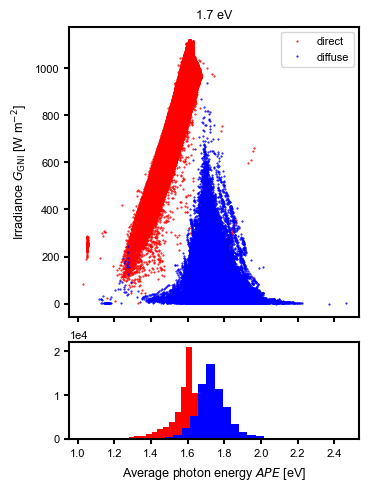

In [36]:
label = "direct normal / diffuse horizontal"
dir_diff_ratio = meteo_data_sync["Direct CHP1-1 [W/m^2]"] / meteo_data_sync["Diffuse CM22-1 (vent/cor) [W/m^2]"]
# dir_diff_ratio = _normalize(dir_diff_ratio)


# direct fraction
dir_diff_threshold = dir_diff_ratio.quantile(0.75) # upper 20 % which are direct
# dir_diff_threshold = 0.7

irradiance = meteo_spectra_filtered.SpecPower[dir_diff_ratio > dir_diff_threshold]
ape_filtered = meteo_spectra_filtered.average_photon_energy[dir_diff_ratio > dir_diff_threshold]

fig, ax = plt.subplots(2,1, gridspec_kw={"height_ratios": [3, 1], "width_ratios": [1]}, constrained_layout=True, sharex=True)
ax[0].plot(ape_filtered, irradiance, "r.", ms=1)  # None, ape_filtered, marker = '.', cmap = "plasma"
ax[1].hist(ape_filtered,30, color="r")

# diffuse fraction
dir_diff_threshold = dir_diff_ratio.quantile(0.25)  # lower 20 % which are diffuse
# dir_diff_threshold = 0.2

irradiance = meteo_spectra_filtered.SpecPower[dir_diff_ratio < dir_diff_threshold]
ape_filtered = meteo_spectra_filtered.average_photon_energy[dir_diff_ratio < dir_diff_threshold]

ax[0].plot(ape_filtered, irradiance, "b.",ms=1)
ax[1].hist(ape_filtered,30, color="b")

# sp = ax.scatter(
#     fy_data_filterd["topcurrent"], fy_data_filterd["bottomcurrent"], None, ape_filtered, marker = '.', cmap = "plasma"
# )

ax[0].set_box_aspect(1)
ax[1].set_box_aspect(1/3)
ax[0].legend(['direct','diffuse'])

ax[0].set_title(f"{tc_eg_list[idx_plot]} eV")
ax[1].set_xlabel("Average photon energy $APE$ [eV]")
ax[0].set_ylabel("Irradiance $G_{\mathrm{GNI}}$ [W m$^{-2}$]")
ax[1].ticklabel_format(style='sci', axis='y', scilimits=(0,0))

In [37]:
morning_timedelta = pd.Timedelta(hours=1) # [h]
noon_timedelta = pd.Timedelta(hours=1) # [h]
evening_timedelta = pd.Timedelta(hours=1) # [h]
print(f"{morning_timedelta.components.hours} after sunrise")

1 after sunrise


Text(0, 0.5, 'Top cell current $J_\\mathrm{sc,top}$ [mA cm$^{-2}$]')

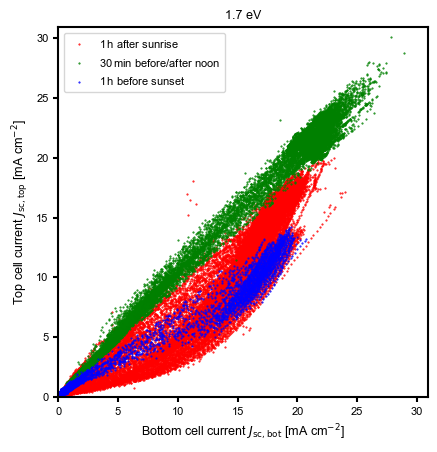

In [38]:
# Set location (latitude, longitude, and timezone) to Golden, CO
location = pvlib.location.Location(39.7555, -105.2211, 'America/Denver')

# Get sunrise and sunset times
sunrise_sunset = location.get_sun_rise_set_transit(currents.index.tz_localize(location.tz), method='spa')


dir_diff_threshold = dir_diff_ratio.quantile(0.0)

morning_timedelta = pd.Timedelta(hours=1) # [h]
noon_timedelta = pd.Timedelta(hours=0.5) # [h]
evening_timedelta = pd.Timedelta(hours=1) # [h]

fig, ax = plt.subplots(1)

currents_filterd = currents[(currents.index.tz_localize(location.tz) < sunrise_sunset['sunrise'] + morning_timedelta) & (dir_diff_ratio > dir_diff_threshold)]
# fy_data_filterd = fy_data[(fy_data.index.hour < morning)]
ax.plot(currents_filterd.iloc[:, 2 * idx_plot+1], currents_filterd.iloc[:, 2 * idx_plot], "r.", ms = 1)

currents_filterd = currents[(currents.index.tz_localize(location.tz)  > sunrise_sunset['transit'] - noon_timedelta) & (currents.index.tz_localize(location.tz) < sunrise_sunset['transit'] + noon_timedelta) & (dir_diff_ratio > dir_diff_threshold)]
# fy_data_filterd = fy_data[(fy_data.index.hour > morning_noon) & (fy_data.index.hour < noon_evening)]
ax.plot(currents_filterd.iloc[:, 2 * idx_plot+1], currents_filterd.iloc[:, 2 * idx_plot], "g.", ms = 1)

currents_filterd = currents[(currents.index.tz_localize(location.tz) > sunrise_sunset['sunset'] - evening_timedelta) & (dir_diff_ratio > dir_diff_threshold)]
# fy_data_filterd = fy_data[(fy_data.index.hour > evening)]
ax.plot(currents_filterd.iloc[:, 2 * idx_plot+1], currents_filterd.iloc[:, 2 * idx_plot], "b.", ms = 1)


ax.set_box_aspect(1)
ax.set_xlim(0, max_current)
ax.set_ylim(0, max_current)
ax.legend([f"{morning_timedelta.components.hours}$\,$h after sunrise", f"{noon_timedelta.components.minutes}$\,$min before/after noon", f"{evening_timedelta.components.hours}$\,$h before sunset"])
ax.set_title(f"{tc_eg_list[idx_plot]} eV")
ax.set_xlabel("Bottom cell current $J_\mathrm{sc,bot}$ [mA cm$^{-2}$]")
ax.set_ylabel("Top cell current $J_\mathrm{sc,top}$ [mA cm$^{-2}$]")



Text(0, 0.5, 'Irradiance $G_{\\mathrm{GNI}}$ [W m$^{-2}$]')

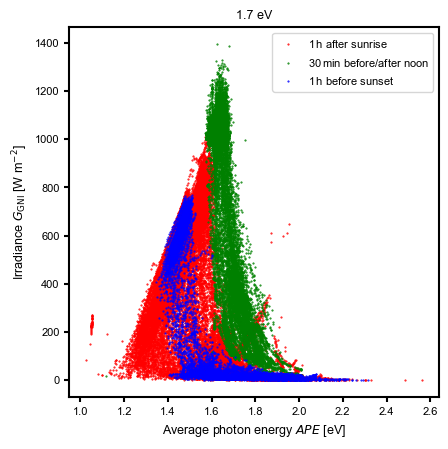

In [39]:
fig, ax = plt.subplots(1)

irradiance = meteo_spectra_filtered.SpecPower
ape = meteo_spectra_filtered.average_photon_energy

ape_filtered = ape[(meteo_spectra_filtered.daytime.tz_localize(location.tz) < sunrise_sunset['sunrise'] + morning_timedelta) & (dir_diff_ratio > dir_diff_threshold)]
irradiance_filtered = irradiance[(meteo_spectra_filtered.daytime.tz_localize(location.tz) < sunrise_sunset['sunrise'] + morning_timedelta) & (dir_diff_ratio > dir_diff_threshold)]
ax.plot(ape_filtered, irradiance_filtered, "r.", ms = 1)

ape_filtered = ape[(meteo_spectra_filtered.daytime.tz_localize(location.tz)  > sunrise_sunset['transit'] - noon_timedelta) & (meteo_spectra_filtered.daytime.tz_localize(location.tz) < sunrise_sunset['transit'] + noon_timedelta) & (dir_diff_ratio > dir_diff_threshold)]
irradiance_filtered = irradiance[(meteo_spectra_filtered.daytime.tz_localize(location.tz)  > sunrise_sunset['transit'] - noon_timedelta) & (meteo_spectra_filtered.daytime.tz_localize(location.tz) < sunrise_sunset['transit'] + noon_timedelta) & (dir_diff_ratio > dir_diff_threshold)]
ax.plot(ape_filtered, irradiance_filtered, "g.", ms = 1)

ape_filtered = ape[(meteo_spectra_filtered.daytime.tz_localize(location.tz) > sunrise_sunset['sunset'] - evening_timedelta) & (dir_diff_ratio > dir_diff_threshold)]
irradiance_filtered = irradiance[(meteo_spectra_filtered.daytime.tz_localize(location.tz) > sunrise_sunset['sunset'] - evening_timedelta) & (dir_diff_ratio > dir_diff_threshold)]
ax.plot(ape_filtered, irradiance_filtered, "b.", ms = 1)


ax.set_box_aspect(1)
ax.legend([f"{morning_timedelta.components.hours}$\,$h after sunrise", f"{noon_timedelta.components.minutes}$\,$min before/after noon", f"{evening_timedelta.components.hours}$\,$h before sunset"])
ax.set_title(f"{tc_eg_list[idx_plot]} eV")
ax.set_xlabel("Average photon energy $APE$ [eV]")
ax.set_ylabel("Irradiance $G_{\mathrm{GNI}}$ [W m$^{-2}$]")



Bin APE

In [40]:
nr_of_ape_bins = 10
nr_of_temp_bins = 5

every 20 of 17980 5.0%
899 of 17980 5.0%


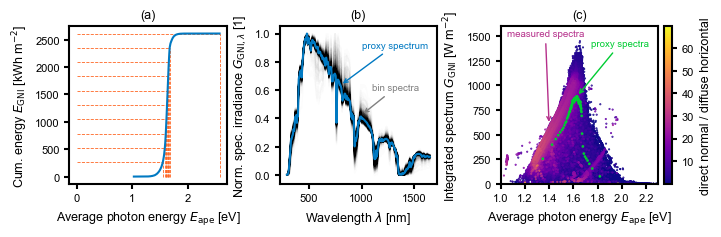

In [47]:
export_plots = False
dir_diff_ratio = meteo_data_sync["Direct CHP1-1 [W/m^2]"] / meteo_data_sync["Diffuse CM22-1 (vent/cor) [W/m^2]"]


ape_dataframe = get_ape_df(meteo_spectra_filtered)
ape_bin_mids, ape_bin_edges, ape_bin_counts = ape_binning(
    nr_of_ape_bins=nr_of_ape_bins, ape_dataframe=ape_dataframe, plot_binning=False, export=export_plots
)

# Loop over all APE bins and average the spectra. Assign each spectra a time delta. Multiply the corresponding spectrum with the time delta. Sum over all spectra and divide by the total time in that bin.
ape_spectra = get_ape_spectra(
    ape_bin_mids, ape_bin_edges, meteo_spectra_filtered, ape_dataframe, plot_spectra=True, export=export_plots, dir_diff_ratio=dir_diff_ratio
)

# ape_bin_mids, ape_bin_edges, ape_bin_counts = ape_binning_equal_dAPE(
#     nr_of_ape_bins=nr_of_ape_bins, ape_dataframe=ape_dataframe, plot_binning=True, export=export_plots
# )
# ape_spectra = get_ape_spectra(
#     ape_bin_mids, ape_bin_edges, meteo_spectra_filtered, ape_dataframe, plot_spectra=True, export=export_plots
# )



lower APE bound = 1.50 eV - upper APE bound = 1.70 eV


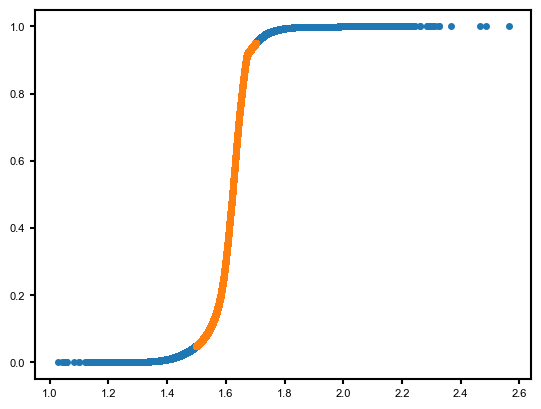

In [42]:
ape_energy = ape_dataframe["SpecPower"] * 60

# ape_energy = ape_energy.sort_values()
ape_energy = ape_energy.sort_index()
ape_energy_cs = ape_energy.cumsum()
ape_energy_cs_norm = ape_energy_cs.values/ape_energy_cs.values[-1]
fig,ax = plt.subplots()
ax.plot(ape_energy_cs.index, ape_energy_cs_norm,".")
e_threshold = 0.05
e_threshold_filter = (ape_energy_cs_norm>e_threshold) & (ape_energy_cs_norm < 1-e_threshold)
ax.plot(ape_energy_cs.index[e_threshold_filter], ape_energy_cs_norm[e_threshold_filter],".")
ape_energy[e_threshold_filter].sum() / ape_energy.sum()

print(f"lower APE bound = {ape_energy[e_threshold_filter].index.min():.2f} eV - upper APE bound = {ape_energy[e_threshold_filter].index.max():.2f} eV")

Using the mean dev3T

In [43]:
cols = [
    "Eg",
    "EgsPsc",
    "EgsSi",
    "totalTime",
    "binCount",
    "ape",
    "temp",
    "ape_bin_width",
    "temp_bin_width",
    "powerIn",
    "power2Tout",
    "power4Tout",
    "psc_jscs",
    "psc_vocs",
    "psc_ffs",
    "si_jscs",
    "si_vocs",
    "si_ffs",
    "rs_top",
    "jsc_bot_loss",
]

# Additional losses for 4T
# additional top series resistance
rs_top_list = [0, 3.731540] # Ohm c^2
rs_top_list = [0, 3.731540/2] # Ohm c^2
jsc_bot_loss_list = [1, 0.95] # percentage loss

rs_top_list = [0] # Ohm c^2
jsc_bot_loss_list = [1] # percentage loss

# binning_results = pd.DataFrame(np.zeros([len(tc_eg_list) * nr_of_ape_bins * nr_of_temp_bins * len(rs_top_list) * len(jsc_bot_loss_list), len(cols)]), columns=cols)
binning_results = pd.DataFrame(np.zeros([nr_of_ape_bins * nr_of_temp_bins * len(rs_top_list) * len(jsc_bot_loss_list), len(cols)]), columns=cols)

row_counter = 0

assert (ape_dataframe["timestamps"] == meteo_spectra_filtered.spectra.index).all()

irradiance = []
total_bin_energy = []

inital_rs_top = mean_dev3T.top.Rser

for rs_top in rs_top_list:
    for jsc_bot_loss in jsc_bot_loss_list:
    
        for idx_ape in trange(len(ape_bin_mids)):
            # get a mask for the current APE bin range
            ape_bin_mask = (ape_dataframe.index > ape_bin_edges[idx_ape]) & (ape_dataframe.index <= ape_bin_edges[idx_ape + 1])
            # filter the spectra with this mask to get all spectra for this APE range
            bin_spectra = meteo_spectra_filtered.spectra[ape_bin_mask]

            # get the timestamps and determine time deltas for each spectra
            bin_times = bin_spectra.index
            bin_time_deltas = bin_times.to_series().diff().astype(np.int64) / 1e9
            _, day_idx = np.unique(bin_time_deltas.index.date, return_index=True)
            # assume that the time delta at the beginning of a day is 60 seconds to avoid night artifacts
            bin_time_deltas[day_idx] = 60

            # set all to 60s
            bin_time_deltas[:] = 60

            # weight all spectra with the time and divide by total time to get averaged spectra
            ape_spectra.iloc[idx_ape, :] = np.sum(bin_spectra * bin_time_deltas.values.reshape(-1, 1)) / np.sum(bin_time_deltas)
            
            assert np.isclose(np.sum(bin_spectra * bin_time_deltas.values.reshape(-1, 1)) / np.sum(bin_time_deltas), np.sum(bin_spectra) / len(bin_time_deltas)).all()

            # weight all spectra with the energy and divide by total energy to get averaged spectra
            # bin_irradiances = pd.Series(np.trapz(x=bin_spectra.columns.astype(np.float32), y=bin_spectra), index=bin_spectra.index)
            # bin_energies = bin_irradiances * bin_time_deltas
            # total_bin_energy.append(np.sum(bin_energies))

            # ape_spectra.iloc[idx_ape, :] = np.sum(bin_spectra * bin_energies.values.reshape(-1, 1)) / np.sum(bin_energies)

            irradiance.append(np.trapz(x=ape_spectra.columns.astype(np.float32), y=ape_spectra.iloc[idx_ape, :]))

            # bin temperature in each bin
            # apebin_temps = ape_dataframe["TempCell"][ape_bin_mask]
            if ape_dataframe["TempCell"][ape_bin_mask].empty:
                continue
            bin_temps = pd.cut(ape_dataframe["TempCell"][ape_bin_mask], bins=nr_of_temp_bins, include_lowest=True)
            bin_temps_unique = bin_temps.value_counts()
            for bin_temp in bin_temps_unique.index:
                bin_temp_mask = bin_temps == bin_temp

                if not any(bin_temp_mask):
                    # raise ValueError("Empty temperature mask")
                    continue

                bin_temp_times = bin_time_deltas[bin_temp_mask.values] 

                # for id_eg in range(len(tc_eg_list)):
                for id_eg in [3]:
                    
                    eg = tc_eg_list[id_eg]    

                    psc_params, si_params = get_jv_params(fp_psk_jv[eg], fp_si_jv)
                    df_tandem_eqe, df_si_eqe_interp = get_tandem_eqe(fp_psk_eqe[eg], fp_psk_trans[eg], fp_si_eqe, psc_params, si_params)
                    # df_tandem_eqe, meteo_spectra_filtered.spectra = match_eqe_spectra(df_tandem_eqe, meteo_spectra_filtered.spectra)
                    df_psk_eqe_interp = df_tandem_eqe.iloc[:, 0]
                    df_si_eqe_filtered = df_tandem_eqe.iloc[:, 1]
                    
                    # scale eqe such that they correspong to linear current fit at 1 sun               
                    jext_top = np.polyval(psc_jsc_fit_res,eg)
                    jext_bot = np.polyval(si_jsc_fit_res,eg)
                    
                    jext_top_eqe_1sun = integrate_eqe(df_psk_eqe_interp) / 1e3
                    jext_bot_eqe_1sun = integrate_eqe(df_si_eqe_filtered) / 1e3
                    
                    jtop_scale =  jext_top / jext_top_eqe_1sun
                    jbot_scale =  jext_bot / jext_bot_eqe_1sun
                    
                    df_psk_eqe_interp = df_psk_eqe_interp * jtop_scale
                    df_si_eqe_filtered = df_si_eqe_filtered * jbot_scale
                    
                    # make sure scaling is correct
                    assert np.isclose(integrate_eqe(df_psk_eqe_interp)[0] / 1e3, jext_top, rtol=1e-2)
                    assert np.isclose(integrate_eqe(df_si_eqe_filtered)[0] / 1e3, jext_bot, rtol=1e-2)
                    
                    # get the currents considering the real outdoor spectra            
                    # psc_jscs = integrate_eqe(df_psk_eqe_interp, ape_spectra.iloc[idx_ape, :])
                    # si_jscs = integrate_eqe(df_si_eqe_filtered, ape_spectra.iloc[idx_ape, :])
                    
                    # considering the band gap shift
                    eg_si, sigma_si = calc_Eg_Rau(df_si_eqe_interp)
                    eg_psc, sigma_psc = calc_Eg_Rau(df_psk_eqe_interp)

                    eg_si, sigma_si = calc_Eg_Rau(df_si_eqe_interp)
                    egs_si = si_eg_shift(bin_temp.mid, eg_si)
                    sigmas_si = si_sigma_shift(bin_temp.mid, sigma_si)

                    eg_psc, sigma_psc = calc_Eg_Rau(df_psk_eqe_interp)
                    egs_psc = psc_eg_shift(bin_temp.mid, eg_psc)
                    sigmas_psc = psc_sigma_shift(bin_temp.mid, sigma_psc)
                    
                    # simple band gap shift                    
                    # si_jscs = shift_eqe(df_si_eqe_filtered, eg_si, sigma_si, [egs_si], [sigmas_si], ape_spectra.iloc[idx_ape, :])
                    # psc_jscs = shift_eqe(df_psk_eqe_interp, eg_psc, sigma_psc, [egs_psc], [sigmas_psc], ape_spectra.iloc[idx_ape, :])
                    
                    # considering bangap shift and high energy tail reduction of the bottom cell
                    psc_jscs, si_jscs = shift_eqe_tcbc(df_psk_eqe_interp, eg_psc, sigma_psc, [egs_psc], [sigmas_psc], df_si_eqe_filtered, eg_si, sigma_si, [egs_si], [sigmas_si], ape_spectra.iloc[idx_ape, :])
                    
                    powerIn = np.trapz(x=ape_spectra.columns, y=ape_spectra.iloc[idx_ape, :])
                    mean_dev3T.top.set(Jext=psc_jscs / 1e3, TC=bin_temp.mid, Eg=egs_psc)
                    mean_dev3T.bot.set(Jext=si_jscs / 1e3, TC=bin_temp.mid, Eg=egs_si)


                    mean_dev3T.top.set(Rser = inital_rs_top)
                    _, iv3t = mean_dev3T.CM()
                    power2T = iv3t.Ptot[0]
                    
                    mean_dev3T.top.set(Rser = inital_rs_top + rs_top)
                    mean_dev3T.bot.set(Jext=si_jscs / 1e3 * jsc_bot_loss, TC=bin_temp.mid)
                    
                    iv3t = mean_dev3T.MPP()
                    power4T = iv3t.Ptot[0]
                    
                    ptop = np.abs(iv3t.Ito * iv3t.Vzt)[0]
                    pbot = np.abs(iv3t.Iro * iv3t.Vrz)[0]
                    
                    iv3t = mean_dev3T.Isc3()
                    isc_top = np.abs(iv3t.Ito[0])
                    isc_bot = np.abs(iv3t.Iro[0])

                    iv3t = mean_dev3T.Voc3()
                    voc_top = np.abs(iv3t.Vzt[0])
                    voc_bot = np.abs(iv3t.Vrz[0])

                    binning_results.at[row_counter, "Eg"] = eg
                    binning_results.at[row_counter, "EgsPsc"] = egs_psc
                    binning_results.at[row_counter, "EgsSi"] = egs_si                    
                    binning_results.at[row_counter, "totalTime"] = np.sum(bin_temp_times) # [s]
                    binning_results.at[row_counter, "binCount"] = bin_temps_unique[bin_temp]
                    # binning_results.at[row_counter, "ape"] = ape_bin_mids[idx_ape]
                    binning_results.at[row_counter, "ape"] = ape_spectra.index[idx_ape]
                    binning_results.at[row_counter, "temp"] = bin_temp.mid
                    binning_results.at[row_counter, "ape_bin_width"] = ape_bin_edges[idx_ape + 1] - ape_bin_edges[idx_ape]
                    binning_results.at[row_counter, "temp_bin_width"] = bin_temp
                    binning_results.at[row_counter, "powerIn"] = powerIn
                    binning_results.at[row_counter, "power2Tout"] = power2T
                    binning_results.at[row_counter, "power4Tout"] = power4T
                    binning_results.at[row_counter, "psc_jscs"] = psc_jscs
                    binning_results.at[row_counter, "psc_vocs"] = voc_top
                    binning_results.at[row_counter, "psc_ffs"] = ptop / isc_top / voc_top
                    binning_results.at[row_counter, "si_jscs"] = si_jscs
                    binning_results.at[row_counter, "si_vocs"] = voc_bot
                    binning_results.at[row_counter, "si_ffs"] = pbot / isc_bot / voc_bot
                    
                    binning_results.at[row_counter, "rs_top"] = rs_top
                    binning_results.at[row_counter, "jsc_bot_loss"] = jsc_bot_loss
                    row_counter += 1
                    
                    
# drop all 0
binning_results = binning_results[~(binning_results == 0).all(axis=1)]


  0%|          | 0/100 [00:00<?, ?it/s]

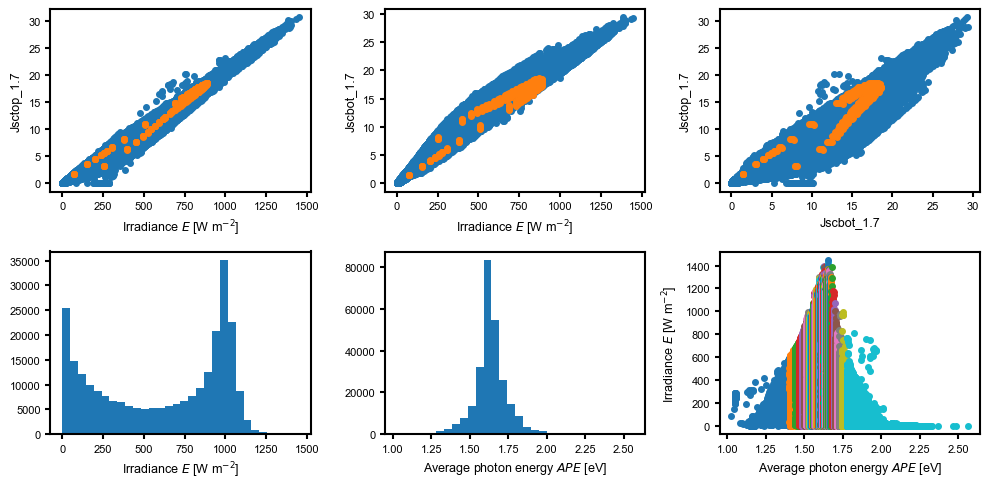

In [44]:
n_choose = 3
resampler = "1T"
fig, ax = plt.subplots(2,3, figsize=(10,5))
# ax[0].plot(currents.resample(resampler).mean().iloc[:, (2 * n_choose) + 1], currents.resample(resampler).mean().iloc[:, (2 * n_choose)], ".")
ax[0,0].plot(meteo_spectra_filtered.SpecPower, currents.iloc[:, (2 * n_choose)], ".")
ax[0,0].set_ylabel(currents.resample(resampler).mean().columns[(2 * n_choose)])
ax[0,0].set_xlabel("Irradiance $E$ [W m$^{-2}$]")

ax[0,1].plot(meteo_spectra_filtered.SpecPower, currents.iloc[:, (2 * n_choose) + 1], ".")
ax[0,1].set_ylabel(currents.resample(resampler).mean().columns[(2 * n_choose) + 1])
ax[0,1].set_xlabel("Irradiance $E$ [W m$^{-2}$]")

ax[0,2].plot(currents.resample(resampler).mean().iloc[:, (2 * n_choose) + 1], currents.resample(resampler).mean().iloc[:, (2 * n_choose)], ".")
ax[0,2].set_xlabel(currents.resample(resampler).mean().columns[(2 * n_choose) + 1])
ax[0,2].set_ylabel(currents.resample(resampler).mean().columns[(2 * n_choose)])

n_choose = 0
binning_results_groups = binning_results.groupby(["Eg"])
group_names = list(binning_results_groups.groups.keys())
bin_group = binning_results_groups.get_group(group_names[n_choose])
ax[0,0].plot(bin_group["powerIn"], bin_group["psc_jscs"],".")
ax[0,1].plot(bin_group["powerIn"], bin_group["si_jscs"],".")
ax[0,2].plot(bin_group["si_jscs"], bin_group["psc_jscs"],".")

ax[1,0].hist(meteo_spectra_filtered.SpecPower,30)
ax[1,0].set_xlabel("Irradiance $E$ [W m$^{-2}$]")
ax[1,1].hist(meteo_spectra_filtered.average_photon_energy,30)
ax[1,1].set_xlabel("Average photon energy $APE$ [eV]")

for idx_ape in range(len(ape_bin_mids)):
    ape_bin_mask = (ape_dataframe.index > ape_bin_edges[idx_ape]) & (ape_dataframe.index <= ape_bin_edges[idx_ape + 1])
    ax[1,2].plot(ape_dataframe[ape_bin_mask]["SpecPower"],".")
    
    
ax[1,2].set_xlabel("Average photon energy $APE$ [eV]")
ax[1,2].set_ylabel("Irradiance $E$ [W m$^{-2}$]")


plt.tight_layout()

Text(0, 0.5, 'Irradiance $G_{\\mathrm{GNI}}$ [W m$^{-2}$]')

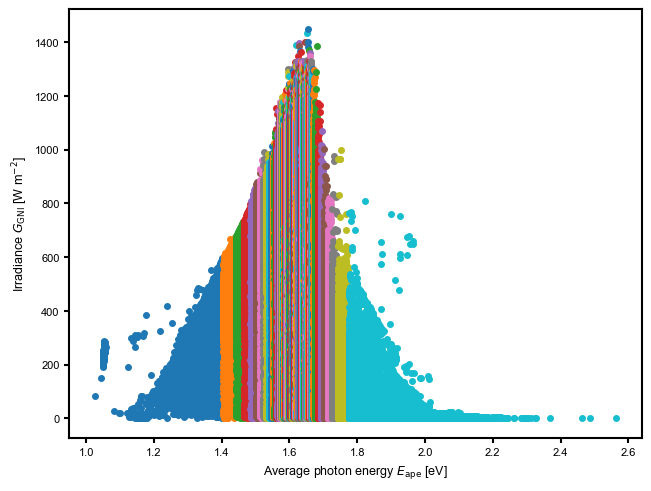

In [45]:
fig, ax = plt.subplots(1, constrained_layout=True)
for idx_ape in range(len(ape_bin_mids)):
    ape_bin_mask = (ape_dataframe.index > ape_bin_edges[idx_ape]) & (ape_dataframe.index <= ape_bin_edges[idx_ape + 1])
    ax.plot(ape_dataframe[ape_bin_mask]["SpecPower"],".")
    
    
ax.set_xlabel("Average photon energy $E_\mathrm{ape}$ [eV]")
ax.set_ylabel("Irradiance $G_{\mathrm{GNI}}$ [W m$^{-2}$]")


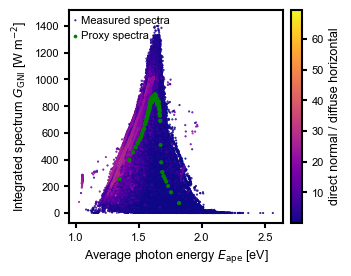

In [46]:
binning_results_groups = binning_results.groupby(["Eg","rs_top","jsc_bot_loss"])
group_names = list(binning_results_groups.groups.keys())

# fig, ax = plt.subplots(2,1, gridspec_kw={"height_ratios": [3, 1], "width_ratios": [1]}, constrained_layout=True, sharex=True, figsize=fig_onecol)
fig, ax = plt.subplots(1,1, constrained_layout=True, figsize=fig_onecol)

marker_scaler = 3600
totalEnergy = np.sum(bin_group["powerIn"] * bin_group["totalTime"])
dir_diff_ratio = meteo_data_sync["Direct CHP1-1 [W/m^2]"] / meteo_data_sync["Diffuse CM22-1 (vent/cor) [W/m^2]"]

# sp = ax[0].scatter(
#     meteo_spectra_filtered.average_photon_energy, meteo_spectra_filtered.SpecPower, 1, dir_diff_ratio, marker=".", cmap="plasma"
# )
sp = ax.scatter(
    meteo_spectra_filtered.average_photon_energy, meteo_spectra_filtered.SpecPower, 1, dir_diff_ratio, marker=".", cmap="plasma"
)

fig.colorbar(sp, ax=ax, label=label, fraction=0.05,
            pad=0.04)
# ax[0].scatter(bin_group["ape"], bin_group["powerIn"], bin_group["powerIn"] * bin_group["totalTime"] / totalEnergy * marker_scaler, None, marker=".",  color='k')
ax.scatter(bin_group["ape"], bin_group["powerIn"], bin_group["powerIn"] * bin_group["totalTime"] / totalEnergy * marker_scaler, None, marker=".",  color='g')
ax.set_box_aspect(1)

# fig.colorbar(sp, ax=ax[0], label=label)

# ax[1].bar(bin_group["ape"], bin_group["powerIn"] * bin_group["totalTime"] / totalEnergy, color=(1,0.5,0), width=0.005)


ax.set_ylabel("Integrated spectrum $G_{\mathrm{GNI}}$ [W m$^{-2}$]")
# ax[0].set_ylabel("Integrated spectrum $G_{\mathrm{GNI}}$ [W m$^{-2}$]")
# ax[1].set_xlabel("Average photon energy $E_\mathrm{ape}$ [eV]")
ax.set_xlabel("Average photon energy $E_\mathrm{ape}$ [eV]")
# ax[1].set_ylabel("Energy fraction")
# ax[1].set_yscale("log")
# ax[1].ticklabel_format(style='sci', axis='y', scilimits=(0,0))

ax.legend(['Measured spectra', 'Proxy spectra'], loc='upper left', facecolor='none', handletextpad=-.5, frameon=False, bbox_to_anchor=(-.05, 1), borderpad=0)
# fig.savefig(rf'C:\Users\rwitteck\OneDrive - NREL\Publications\2023\EHE-paper\Tex\figures\irr_eape.pdf', format="pdf", bbox_inches = 'tight')
# fig.savefig(fr'C:\Users\rwitteck\OneDrive - NREL\Publications\2023\EHE-paper\Tex\figures\eape_irr.{"pdf"}')

In [47]:
# with open('bin_res_eqAPE.p', 'wb') as fout:
#     pickle.dump(binning_results,fout)

C:\Users\rwitteck\AppData\Local\Temp\1\ipykernel_17356\4178750104.py:40: RuntimeWarning: invalid value encountered in scalar divide
  rs_col = (rs - rs_min)/rs_span
C:\Users\rwitteck\AppData\Local\Temp\1\ipykernel_17356\4178750104.py:41: RuntimeWarning: invalid value encountered in scalar divide
  optloss_col = (optloss - optloss_min)/optloss_span


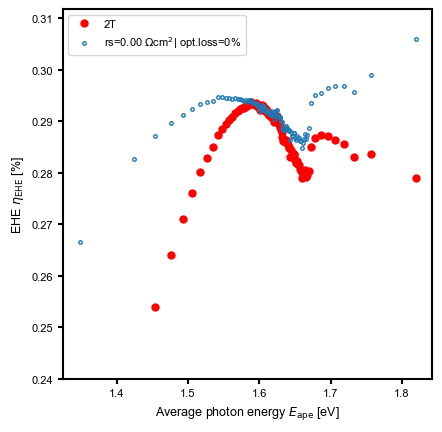

In [48]:
binning_results_groups = binning_results.groupby(["Eg","rs_top","jsc_bot_loss"])
group_names = list(binning_results_groups.groups.keys())

rs_span = np.array(group_names)[:,1].max() - np.array(group_names)[:,1].min()
optloss_span = np.array(group_names)[:,2].max() - np.array(group_names)[:,2].min()
rs_min = np.array(group_names)[:,1].min()
optloss_min = np.array(group_names)[:,2].min()

fig, ax = plt.subplots()
bin_group = binning_results_groups.get_group(group_names[0]).copy()

markers = itertools.cycle(['.','s','*'])
rs0  = group_names[0][1]
marker = next(markers)

# calculate energy in and energy out for each temperature
bin_group['energyIn'] = bin_group["powerIn"] * bin_group["totalTime"]
bin_group['energy2TOut'] = bin_group["power2Tout"] * bin_group["totalTime"]
bin_group['energy4TOut'] = bin_group["power4Tout"] * bin_group["totalTime"]    
# sum energies
bin_group = bin_group.groupby(['ape']).sum(numeric_only=True).reset_index()
# ax.plot(bin_group["ape"], bin_group['energy2TOut'], "ro", ms=5,label="2T")
ax.plot(bin_group["ape"], bin_group['energy2TOut']/bin_group['energyIn'] * 1e4, "ro", ms=5,label="2T")

# sort group names based on rs ascending and opt loss descending
group_names = sorted(group_names, key=lambda x: (x[1], -x[2]))

for group_name in group_names[:1]:
    bin_group = binning_results_groups.get_group(group_name).copy()
    
    # calculate energy in and energy out for each temperature
    bin_group['energyIn'] = bin_group["powerIn"] * bin_group["totalTime"]
    bin_group['energy2TOut'] = bin_group["power2Tout"] * bin_group["totalTime"]
    bin_group['energy4TOut'] = bin_group["power4Tout"] * bin_group["totalTime"]    
    # sum energies
    bin_group = bin_group.groupby(['ape']).sum(numeric_only=True).reset_index()
    
    eg,rs,optloss = group_name
    # make color based on rs and optical loss
    rs_col = (rs - rs_min)/rs_span
    optloss_col = (optloss - optloss_min)/optloss_span
    
    if not rs == rs0:
        rs0 = rs
        marker = next(markers)

    # ax.plot(bin_group["ape"], bin_group['energy4TOut'], marker, mfc="None", ms=5,label=f"rs={rs} | opt.loss={(1-optloss)*100:.0f}%")
    ax.plot(bin_group["ape"], bin_group['energy4TOut']/bin_group['energyIn'] * 1e4, marker, mfc="None", ms=5,label=f"rs={rs:.2f} $\\Omega$cm$^{2}$| opt.loss={(1-optloss)*100:.0f}%")

# # limits
# # captions
ax.set_xlabel("Average photon energy $E_\mathrm{ape}$ [eV]")
ax.set_ylabel("EHE $\eta_\mathrm{EHE}$ [%]")
# anno = ax.annotate(f"$\\eta_\mathrm{{mean}}$ = {mean_group_eta:.3f}",xy=(0.15,0.8), xycoords='figure fraction', fontsize=12)
# anno = ax.annotate(f"$\\eta_\mathrm{{median}}$ = {median_group_eta:.3f}" ,xy=(0.15,0.8), xycoords='figure fraction', fontsize=12)

ax.set_ylim(bottom = 0.24)

ax.set_box_aspect(1)
ax.legend(loc="best")



0.8991504602161802
lower APE bound = 1.55 eV - upper APE bound = 1.67 eV


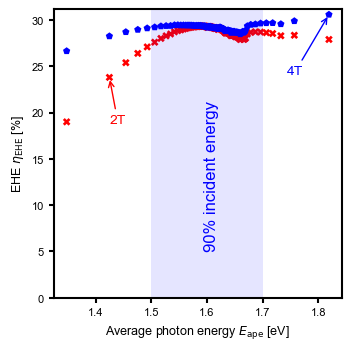

In [49]:
fig, ax = plt.subplots(1,1, constrained_layout=True, figsize=fig_onecol)


binning_results_groups = binning_results.groupby(["Eg","rs_top","jsc_bot_loss"])
group_names = list(binning_results_groups.groups.keys())

n_choose = 0

bin_group = binning_results_groups.get_group(group_names[n_choose]).copy()

totalEnergy = np.sum(bin_group["powerIn"] * bin_group["binCount"])

# calculate energy in and energy out for each temperature
bin_group['energyIn'] = bin_group["powerIn"] * bin_group["totalTime"]
bin_group['energy2TOut'] = bin_group["power2Tout"] * bin_group["totalTime"]
bin_group['energy4TOut'] = bin_group["power4Tout"] * bin_group["totalTime"]    
# sum energies
bin_group = bin_group.groupby(['ape']).sum(numeric_only=True).reset_index()

# eta_group = eta_group[eta_group["binCount"] > 0]
marker_scaler = 50

cmap = plt.colormaps.get("plasma")

sp = ax.scatter(
    bin_group["ape"],
    (bin_group["energy2TOut"]) / (bin_group["energyIn"]) * 1e4 * 100,
    bin_group["energyIn"] / totalEnergy * marker_scaler,
    # eta_group["powerIn"],# * eta_group["totalTime"] / 3600 / 1e3,
    # (eta_group["powerIn"] * eta_group["totalTime"])/5e5,
    None,
    marker="X",
    # cmap=cmap,
    color = 'r',
    label = '2T',
    edgecolors='none',
    linewidths=0,
    # norm = "log",
    # vmin=0,
    # vmax = max_eta
)
sp = ax.scatter(
    bin_group["ape"],
    (bin_group["energy4TOut"]) / (bin_group["energyIn"]) * 1e4 * 100,
    bin_group["energyIn"] / totalEnergy * marker_scaler,
    # eta_group["powerIn"],# * eta_group["totalTime"] / 3600/ 1e3,
    # (eta_group["powerIn"] * eta_group["totalTime"])/5e5,
    None,
    marker="p",
    # cmap=cmap,
    color = 'b',
    label = '4T',
    edgecolors='none',
    linewidths=0,
    # norm = "log",
    # vmin=0,
    # vmax = max_eta
)

# # limits
# # captions
# ax.set_title(f"TC bandgap {group_names[n_choose]} eV - {bin_group.shape[0]} bins")
ax.set_xlabel("Average photon energy $E_\mathrm{ape}$ [eV]")
ax.set_ylabel("EHE $\eta_\mathrm{EHE}$ [%]")
# anno = ax.annotate(f"$\\eta_\mathrm{{mean}}$ = {mean_group_eta:.3f}",xy=(0.15,0.8), xycoords='figure fraction', fontsize=12)
# anno = ax.annotate(f"$\\eta_\mathrm{{median}}$ = {median_group_eta:.3f}" ,xy=(0.15,0.8), xycoords='figure fraction', fontsize=12)

y_lowerlim = 0.95 * np.min([np.min((bin_group["power2Tout"] * bin_group["totalTime"]) / (bin_group["powerIn"] * bin_group["totalTime"]) * 1e4), np.min((bin_group["power4Tout"] * bin_group["totalTime"]) / (bin_group["powerIn"] * bin_group["totalTime"]) * 1e4)])
ax.set_ylim(bottom = 0)

# draw patch with energy above threshold
e_threshold = 0.9

# sort powerIn descending
pin = bin_group.sort_values('powerIn',ascending=False)

# filter all energies below threshold 
max_e_filter = (pin['powerIn'] / pin['powerIn'].sum()).cumsum() <= e_threshold

# find boundary ape for threshold
emin_filter = pin[max_e_filter]['ape'].min()
emax_filter = pin[max_e_filter]['ape'].max()

y_max_lim = ax.get_ylim()[1]

# ax.plot([pin[max_e_filter]['ape'].min(), pin[max_e_filter]['ape'].min()], [0,y_max_lim], 'r--')
# ax.plot([pin[max_e_filter]['ape'].max(), pin[max_e_filter]['ape'].max()], [0,y_max_lim], 'r--')

# sanity check
min_max_filter = (bin_group['ape'] >= emin_filter) & (bin_group['ape'] <= emax_filter)
print(bin_group[min_max_filter]['powerIn'].sum() / bin_group['powerIn'].sum())

# rectangle = mpl.patches.Rectangle((pin[max_e_filter]['ape'].min(), 0), pin[max_e_filter]['ape'].max() - pin[max_e_filter]['ape'].min(), y_max_lim, facecolor=(0,0,1,0.1))
rectangle = mpl.patches.Rectangle((ape_energy[e_threshold_filter].index.min(), 0), ape_energy[e_threshold_filter].index.max() - ape_energy[e_threshold_filter].index.min(), y_max_lim, facecolor=(0,0,1,0.1))
ax.add_patch(rectangle)

ax.text((pin[max_e_filter]['ape'].max() + pin[max_e_filter]['ape'].min())/2, 5, f'{e_threshold*100:.0f}% incident energy', size="large", rotation=90,
                         horizontalalignment='center', verticalalignment='bottom', rotation_mode='default', color=(0,0,1), fontname = 'Arial')
# rx, ry = rectangle.get_xy()
# cx = rx + rectangle.get_width()/2.0
# cy = ry + rectangle.get_height()/2.0
# ax.annotate("Rectangle", (cx, cy), color='black', weight='bold', fontsize=10, ha='center', va='center')

ax.set_box_aspect(1)

x2t = bin_group["ape"]
y2t = (bin_group["energy2TOut"]) / (bin_group["energyIn"]) * 1e4 * 100

x4t = bin_group["ape"]
y4t = (bin_group["energy4TOut"]) / (bin_group["energyIn"]) * 1e4 * 100

ax.annotate("2T", xy=(x2t.iloc[1],y2t.iloc[1]), xycoords='data', xytext = (0,-33), textcoords='offset points', color='r', arrowprops=dict(arrowstyle = '->', color='r'))
ax.annotate("4T", xy=(x4t.iloc[-1],y4t.iloc[-1]), xycoords='data', xytext = (-30,-43), textcoords='offset points', color='b', arrowprops=dict(arrowstyle = '->', color='b'))


# fig.savefig(fr'C:\Users\rwitteck\OneDrive - NREL\Publications\2023\EHE-paper\Tex\figures\2t4t.{"pdf"}', bbox_inches = 'tight')
print(f"lower APE bound = {emin_filter:.2f} eV - upper APE bound = {emax_filter:.2f} eV")

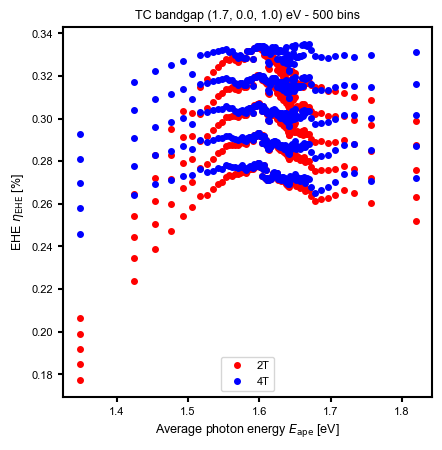

In [50]:
binning_results_groups = binning_results.groupby(["Eg","rs_top","jsc_bot_loss"])
group_names = list(binning_results_groups.groups.keys())


fig, ax = plt.subplots()

n_choose = 0
bin_group = binning_results_groups.get_group(group_names[n_choose]).copy()

ax.plot(bin_group["ape"],(bin_group["power2Tout"] * bin_group["totalTime"]) / (bin_group["powerIn"] * bin_group["totalTime"]) * 1e4,"r.",label = '2T')
ax.plot(bin_group["ape"],(bin_group["power4Tout"] * bin_group["totalTime"]) / (bin_group["powerIn"] * bin_group["totalTime"]) * 1e4,"b.",label = '4T')


# n_choose = 1
# bin_group = binning_results_groups.get_group(group_names[n_choose]).copy()

# ax.plot(bin_group["ape"],(bin_group["power2Tout"] * bin_group["totalTime"]) / (bin_group["powerIn"] * bin_group["totalTime"]) * 1e4,"g.",label = '2T')
# ax.plot(bin_group["ape"],(bin_group["power4Tout"] * bin_group["totalTime"]) / (bin_group["powerIn"] * bin_group["totalTime"]) * 1e4,"m.",label = '4T')


# # captions
ax.set_title(f"TC bandgap {group_names[n_choose]} eV - {bin_group.shape[0]} bins")
ax.set_xlabel("Average photon energy $E_\mathrm{ape}$ [eV]")
ax.set_ylabel("EHE $\eta_\mathrm{EHE}$ [%]")

ax.set_box_aspect(1)
ax.legend(loc="lower center")


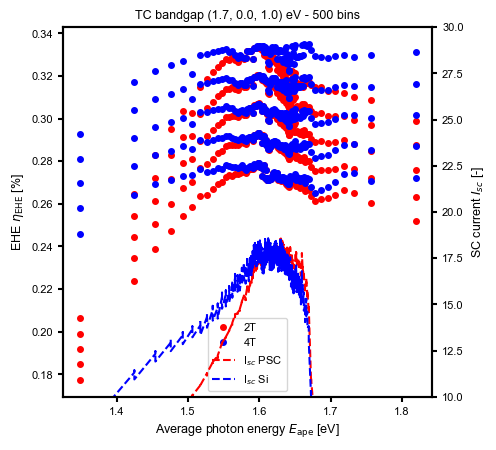

In [51]:
binning_results_groups = binning_results.groupby(["Eg","rs_top","jsc_bot_loss"])
group_names = list(binning_results_groups.groups.keys())

n_choose = group_names.index((1.7, 0.0, 1.0))

bin_group = binning_results_groups.get_group(group_names[n_choose]).copy()

fig, ax = plt.subplots()
ax.plot(bin_group["ape"],(bin_group["power2Tout"] * bin_group["totalTime"]) / (bin_group["powerIn"] * bin_group["totalTime"]) * 1e4,"r.",label = '2T')
ax.plot(bin_group["ape"],(bin_group["power4Tout"] * bin_group["totalTime"]) / (bin_group["powerIn"] * bin_group["totalTime"]) * 1e4,"b.",label = '4T')
ax2 = ax.twinx()
# Current - goes down and can't explain the rise in TC
ax2.plot(bin_group["ape"],bin_group["psc_jscs"],"r--",label = 'I$_{sc}$ PSC')
ax2.plot(bin_group["ape"],bin_group["si_jscs"],"b--",label = 'I$_{sc}$ Si')
# Voltage - goes down and can't explain the rise in TC
# Temperature
# ax2.plot(eta_group["ape"],eta_group["temp"],"k--",label = 'Temp')
# # captions
ax.set_title(f"TC bandgap {group_names[n_choose]} eV - {bin_group.shape[0]} bins")
ax.set_xlabel("Average photon energy $E_\mathrm{ape}$ [eV]")
ax.set_ylabel("EHE $\eta_\mathrm{EHE}$ [%]")
ax2.set_ylabel("SC current $I_{sc}$ [-]")

ax.set_box_aspect(1)
ax2.set_ylim(10,30)


# get handles and labels for both axes' legends
handles1, labels1 = ax.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
handles = handles1 + handles2
labels = labels1 + labels2

ax.legend(handles, labels, loc="lower center")


Comparing total 2T and 4T energy yield

Load full year data

In [52]:
with open("fullyear_global_170.p","rb") as fin:
    fy_data = pickle.load(fin)

In [53]:
ey2T = np.sum(bin_group["power2Tout"] * bin_group["totalTime"] / 60 / 60) # Wh
ey4T = np.sum(bin_group["power4Tout"] * bin_group["totalTime"] / 60 / 60) # Wh
ratio2T4T = ey2T / ey4T
rs = bin_group["rs_top"].unique()[0]
opt_loss = bin_group["jsc_bot_loss"].unique()[0]
print(f"2T EY: {ey2T:.2f}")
print(f"rs = {rs}, optloss={1-opt_loss}, 4T EY: {ey4T:.2f}")
print(f"2T/4T ratio is: {ratio2T4T:.2f}")



2T EY: 74.60
rs = 0.0, optloss=0.0, 4T EY: 76.06
2T/4T ratio is: 0.98


In [54]:
fy_data_filter = (fy_data["P4Tout"] >= 0) & (fy_data["P2Tout"] >= 0)# & (meteo_spectra.average_photon_energy>0)& (meteo_spectra.average_photon_energy<4)
fy_data_filt = fy_data[fy_data_filter]

ey2T = fy_data_filt["P2Tout"].sum() / 60 # Wh
ey4T = fy_data_filt["P4Tout"].sum() / 60 # Wh
ratio2T4T = ey2T / ey4T
print(f" 2T EY: {ey2T:.2f}")
print(f" 4T EY: {ey4T:.2f}")
print(f" 2T/4T ratio is: {ratio2T4T:.2f}")

# deviations are probably from new model - using mean_dev3T and linear current fit instead EQE shift.
print((np.sum(bin_group["power2Tout"] * bin_group["totalTime"] / 60)) / (fy_data_filt["P2Tout"].sum()))
print((np.sum(bin_group["power4Tout"] * bin_group["totalTime"] / 60)) / (fy_data_filt["P4Tout"].sum()))

 2T EY: 74.46
 4T EY: 75.70
 2T/4T ratio is: 0.98
1.0019542127023446
1.0046829193944569


In [55]:
neg_spectra_filter = meteo_spectra.spectra < -1e-2
neg_spectra_filter = (neg_spectra_filter.sum(axis=1)  / meteo_spectra.spectra.shape[1]) > 0.01
# _, meteo_data_sync = sync(meteo_spectra.spectra, meteo_data.data)
# dir_diff_ratio = meteo_data_sync["Direct CHP1-1 [W/m^2]"] / meteo_data_sync["Diffuse CM22-1 (vent/cor) [W/m^2]"]

In [56]:
general_filter = (meteo_spectra.average_photon_energy > 0) & (meteo_spectra.average_photon_energy < 2.2) & (~neg_spectra_filter) & (dir_diff_ratio > 0)
global_filter = (meteo_spectra.spectra.index.month >= 0)# & (meteo_spectra.spectra.index.day == 6)
fy_global = fy_data[general_filter & global_filter]
# fy_global= fy_global[(fy_global["P2Tout"] >=0) & (fy_global["P4Tout"] >=0)]


Align APE and restored full year data

Text(0, 0.5, 'Top cell current $J_\\mathrm{sc,top}$ [mA cm$^{-2}$]')

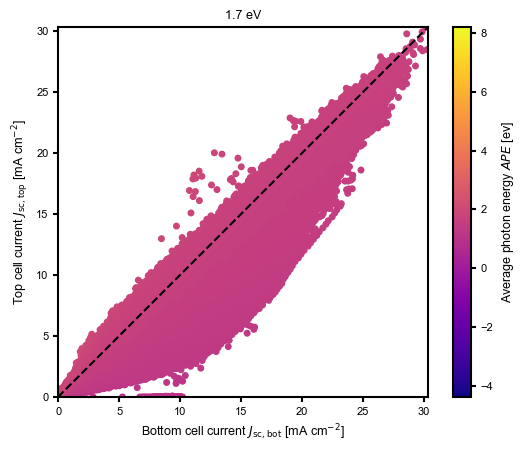

In [57]:
fig, ax = plt.subplots(1)

sp = ax.scatter(
    # fy_data["bottomcurrent"], fy_data["topcurrent"], None, fy_data["P2Tout"] / fy_data["Pin"] * 1e4, marker = '.', cmap = "plasma"
    # fy_data["bottomcurrent"], fy_data["topcurrent"], None, fy_data.index.hour, marker = '.', cmap = "plasma"
    # fy_data["bottomcurrent"], fy_data["topcurrent"], None, fy_data.index.hour * 60 + fy_data.index.minute, marker = '.', cmap = "plasma"
    fy_data["bottomcurrent"], fy_data["topcurrent"], None, meteo_spectra.average_photon_energy, marker = '.', cmap = "plasma"
)
# plt.colorbar(sp, ax=ax, orientation="vertical", label="Energy harvesting efficiency $EHE$ [-]")
# plt.colorbar(sp, ax=ax, orientation="vertical", label="Minute of the day [min]")
plt.colorbar(sp, ax=ax, orientation="vertical", label="Average photon energy $APE$ [ev]")

max_current = max(fy_data["bottomcurrent"].max(), fy_data["topcurrent"].max())

ax.plot([0, max_current], [0, max_current], "k--")
# limits
ax.set_xlim(0, max_current)
ax.set_ylim(0, max_current)
ax.set_box_aspect(1)

ax.set_title(f"{fy_data.Eg[0]} eV")
ax.set_xlabel("Bottom cell current $J_\mathrm{sc,bot}$ [mA cm$^{-2}$]")
ax.set_ylabel("Top cell current $J_\mathrm{sc,top}$ [mA cm$^{-2}$]")


Shot direct and diffuse effect 

C:\Users\rwitteck\AppData\Local\Temp\1\ipykernel_17356\4249939509.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  fy_data_filterd = fy_data[dir_diff_ratio > dir_diff_threshold]


IndexingError: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).

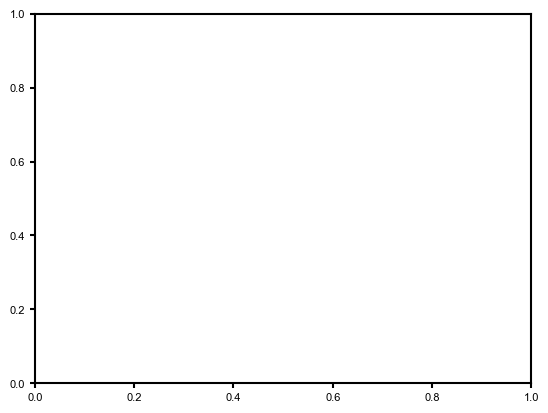

In [58]:
n = 2
resampler = "1T"

_, meteo_sync = sync(fy_data, meteo_data.data)

fig, ax = plt.subplots(1)

# direct part 
dir_diff_threshold = dir_diff_ratio.quantile(0.8)
fy_data_filterd = fy_data[dir_diff_ratio > dir_diff_threshold]
ape_filtered = meteo_spectra.average_photon_energy[dir_diff_ratio > dir_diff_threshold]

ax.plot(fy_data_filterd["bottomcurrent"],fy_data_filterd["topcurrent"], "b.", label = 'direct')

# diffuse part 
dir_diff_ratio = meteo_sync["Direct CHP1-1 [W/m^2]"] / meteo_sync["Diffuse CM22-1 (vent/cor) [W/m^2]"]
dir_diff_threshold = dir_diff_ratio.quantile(0.2)
fy_data_filterd = fy_data[dir_diff_ratio < dir_diff_threshold]

ape_filtered = meteo_spectra.average_photon_energy[dir_diff_ratio < dir_diff_threshold]

ax.plot(fy_data_filterd["bottomcurrent"],fy_data_filterd["topcurrent"], "r.", label = 'diffuse')

max_current = max(fy_data["bottomcurrent"].max(), fy_data["topcurrent"].max()) * 1.02

ax.set_box_aspect(1)
ax.set_xlim(0, max_current)
ax.set_ylim(0, max_current)
ax.set_title(f"TC = {fy_data.Eg[0]} eV")

ax.set_xlabel("Bottom cell current $J_\mathrm{sc,bot}$ [mA cm$^{-2}$]")
ax.set_ylabel("Top cell current $J_\mathrm{sc,top}$ [mA cm$^{-2}$]")
ax.legend()

## Clouds coverage

In [ ]:
clouds = CloudCover.get_asi(date_start, date_end)


In [59]:
def filter_times(ts, min2filt,diff_min2filt):
    # filter values with a time difference of +-2min
    time_filter = (ts.index.minute.values % min2filt <= diff_min2filt) | (np.abs(ts.index.minute.values % min2filt - min2filt) <= diff_min2filt)
    ts_mask = ts[time_filter]
    
    # round all times to 10 min
    ts_mask = ts_mask.set_index(ts_mask.index.round(pd.Timedelta(minutes=min2filt)))

    # calc mean for these values
    # return(ts_mask.resample(pd.Timedelta(minutes=min2filt)).mean())
    return ts_mask.groupby(ts_mask.index.round(pd.Timedelta(minutes=min2filt))).mean()

In [60]:
ape = pd.DataFrame(meteo_spectra_filtered.average_photon_energy, index = meteo_spectra_filtered.spectra.index)
specpower = pd.DataFrame(meteo_spectra_filtered.SpecPower, index = meteo_spectra_filtered.spectra.index)
irradiance = pd.DataFrame(meteo_data.data["Global Normal CMP22 [W/m^2]"])

ape = filter_times(ape.shift(freq='-1T'),10,0)
specpower = filter_times(specpower.shift(freq='-1T'),10,0)
irradiance = filter_times(irradiance.shift(freq='-1T'),10,0)

cloud_data, ape = sync(clouds.data, ape)
_, specpower = sync(clouds.data, specpower)
_, irradiance = sync(specpower, irradiance)

NameError: name 'clouds' is not defined

In [ ]:
sun_coverage = {
    "Sun not visible": 0,
    "Sun on clear sky": 1,
    "Parts of sun cloud covered": 3,
    "Sun behind clouds, but a bright dot is visible": 5,
    "Sun outside view, either because of zenith angle, or sun is hidden by horizon": 8,
    "No Sunflag evaluation was made": 9,
}

fig, ax = plt.subplots(1, figsize=(8,5))

for key, value in sun_coverage.items():
    plot_filter = cloud_data["Sun Flag"].values == value
    ax.plot(ape[plot_filter], specpower[plot_filter], ".", ms=3, label=key, zorder=10-value)

ax.set_xlabel("Average photon energy $E_\mathrm{ape}$ [eV]")
ax.set_ylabel("Irradiance $G_{\mathrm{GNI}}$ [W m$^{-2}$]")
# ax.legend(loc="upper right")
ax.legend(bbox_to_anchor=(0.55, 0.8), loc="center left")
fig.tight_layout()

In [ ]:
CloudImageLoader(ape, specpower, cloud_data, irradiance)
# CloudImageLoader(pd.DataFrame(cloud_data['CDOC Total Cloud Cover [%]']), specpower, cloud_data)
# CloudImageLoader(pd.DataFrame(cloud_data['CDOC Total Cloud Cover [%]']), specpower, cloud_data)

In [ ]:
# cloud_data.loc['2022-04-04 12:20:00']
# print(*[f"{col} = {meteo_data.data.loc['2022-04-04 12:20:00'][col]}" for col in meteo_data.data.loc['2022-04-04 12:20:00'].index if 'W/m' in col], sep='\n')

In [ ]:
sun_coverage = {
    "Sun not visible": 0,
    "Sun on clear sky": 1,
    "Parts of sun cloud covered": 3,
    "Sun behind clouds, but a bright dot is visible": 5,
    "Sun outside view, either because of zenith angle, or sun is hidden by horizon": 8,
    "No Sunflag evaluation was made": 9,
}

fig, ax = plt.subplots(1)

sp = ax.scatter(ape, specpower, [1], cloud_data["BRBG Total Cloud Cover [%]"],marker=".",
    cmap="plasma")

fig.colorbar(sp, ax=ax, orientation="vertical", label="BRBG Total Cloud Cover [%]")

ax.set_xlabel("Average photon energy $E_\mathrm{ape}$ [eV]")
ax.set_ylabel("Irradiance $G_{\mathrm{GNI}}$ [W m$^{-2}$]")
# ax.legend(loc="upper right")


For poster only

In [ ]:
with open(r"C:\Users\rwitteck\OneDrive - NREL\Publications\2023\EHE-paper\Tex\figures\binning_results.p", 'rb') as fin:
    binning_results2 = pickle.load(fin)
    
binning_results2["energy2T"] = (binning_results2["power2Tout"] * binning_results2["totalTime"] / 60) # totalTime is in seconds
binning_results2["energyIn"] = (binning_results2["powerIn"] * binning_results2["totalTime"] / 60) # totalTime is in seconds
bin_energy_yield = binning_results2.groupby(["Eg","NrOfApeBins"]).sum(numeric_only=True)["energy2T"].unstack()
full_energy_yield = fy_global["P2Tout"].sum()  # Time is in minutes.

# plt.plot(bin_energy_yield.loc[bg2plot].index.values.reshape(-1,1) * bin_energy_yield.columns.values,(bin_energy_yield.loc[bg2plot]/full_energy_yield  - 1) * 100, "-s")
# plt.plot(np.array(nr_of_ape_bins) * np.array(nr_of_temp_bins), (ehe_bins/ehe_full - 1) * 100, "-s")

# fig, ax = plt.subplots(2,1, gridspec_kw={"height_ratios": [3, 1], "width_ratios": [1]}, constrained_layout=True, sharex=True, figsize=fig_onecol)
fig, ax = plt.subplots(1,2, constrained_layout=True, figsize=get_figsize(522, fraction = 1, ratio=1,rows=1,cols=2))

marker_scaler = 3600
totalEnergy = np.sum(bin_group["powerIn"] * bin_group["totalTime"])
dir_diff_ratio = meteo_data_sync["Direct CHP1-1 [W/m^2]"] / meteo_data_sync["Diffuse CM22-1 (vent/cor) [W/m^2]"]

# sp = ax[0].scatter(
#     meteo_spectra_filtered.average_photon_energy, meteo_spectra_filtered.SpecPower, 1, dir_diff_ratio, marker=".", cmap="plasma"
# )
sp = ax[0].scatter(
    meteo_spectra_filtered.average_photon_energy, meteo_spectra_filtered.SpecPower, 1, dir_diff_ratio, marker=".", cmap="plasma"
)

fig.colorbar(sp, ax=ax[0], label=label, fraction=0.05,
            pad=0.04)
# ax[0].scatter(bin_group["ape"], bin_group["powerIn"], bin_group["powerIn"] * bin_group["totalTime"] / totalEnergy * marker_scaler, None, marker=".",  color='k')
ax[0].scatter(bin_group["ape"], bin_group["powerIn"], bin_group["powerIn"] * bin_group["totalTime"] / totalEnergy * marker_scaler, None, marker=".",  color='g')
ax[0].set_box_aspect(1)

# fig.colorbar(sp, ax=ax[0], label=label)

# ax[1].bar(bin_group["ape"], bin_group["powerIn"] * bin_group["totalTime"] / totalEnergy, color=(1,0.5,0), width=0.005)


ax[0].set_ylabel("Integrated spectrum $G_{\mathrm{GNI}}$ [W m$^{-2}$]")
ax[0].set_xlabel("Average photon energy $E_\mathrm{ape}$ [eV]")
ax[0].set_box_aspect(1)

ax[1].plot(bin_energy_yield.loc[1.7].index.values.reshape(-1,1),(bin_energy_yield.loc[1.7]/full_energy_yield  - 1) * 100, "*", color=(0, 0, 1, 0.33), mfc=(0, 0, 1, 0.66), mec=(0, 0, 1))

ax[1].legend(bin_energy_yield.columns.astype(int), title=bin_energy_yield.columns.name)
ax[1].set_title("Global irradiance")
ax[1].set_xlabel("Nr of bins")
ax[1].set_ylabel("Deviation bin vs full year [%]")
ax[1].set_ylim(bottom = 0)
ax[1].set_box_aspect(1)

# fig.savefig(rf'C:\Users\rwitteck\OneDrive - NREL\Publications\2023\EHE-paper\Tex\figures\irr_eape_bins.png', format="png", dpi=1200, bbox_inches = 'tight')
# fig.savefig(fr'C:\Users\rwitteck\OneDrive - NREL\Publications\2023\EHE-paper\Tex\figures\eape_irr.{"pdf"}')

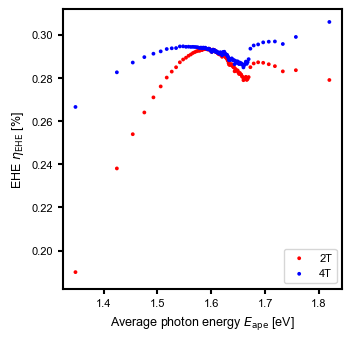

In [61]:
fig, ax = plt.subplots(1,1, constrained_layout=True, figsize=fig_onecol)


binning_results_groups = binning_results.groupby(["Eg","rs_top","jsc_bot_loss"])
group_names = list(binning_results_groups.groups.keys())

n_choose = 0

bin_group = binning_results_groups.get_group(group_names[n_choose]).copy()

totalEnergy = np.sum(bin_group["powerIn"] * bin_group["binCount"])

# calculate energy in and energy out for each temperature
bin_group['energyIn'] = bin_group["powerIn"] * bin_group["totalTime"]
bin_group['energy2TOut'] = bin_group["power2Tout"] * bin_group["totalTime"]
bin_group['energy4TOut'] = bin_group["power4Tout"] * bin_group["totalTime"]    
# sum energies
bin_group = bin_group.groupby(['ape']).sum(numeric_only=True).reset_index()

# eta_group = eta_group[eta_group["binCount"] > 0]
marker_scaler = 50

cmap = plt.colormaps.get("plasma")

sp = ax.scatter(
    bin_group["ape"],
    (bin_group["energy2TOut"]) / (bin_group["energyIn"]) * 1e4,
    bin_group["energyIn"] / totalEnergy * marker_scaler,
    # eta_group["powerIn"],# * eta_group["totalTime"] / 3600 / 1e3,
    # (eta_group["powerIn"] * eta_group["totalTime"])/5e5,
    None,
    marker=".",
    # cmap=cmap,
    color = 'r',
    label = '2T',
    edgecolors='none',
    linewidths=0,
    # norm = "log",
    # vmin=0,
    # vmax = max_eta
)
sp = ax.scatter(
    bin_group["ape"],
    (bin_group["energy4TOut"]) / (bin_group["energyIn"]) * 1e4,
    bin_group["energyIn"] / totalEnergy * marker_scaler,
    # eta_group["powerIn"],# * eta_group["totalTime"] / 3600/ 1e3,
    # (eta_group["powerIn"] * eta_group["totalTime"])/5e5,
    None,
    marker=".",
    # cmap=cmap,
    color = 'b',
    label = '4T',
    edgecolors='none',
    linewidths=0,
    # norm = "log",
    # vmin=0,
    # vmax = max_eta
)

# # limits
# # captions
# ax.set_title(f"TC bandgap {group_names[n_choose]} eV - {bin_group.shape[0]} bins")
ax.set_xlabel("Average photon energy $E_\mathrm{ape}$ [eV]")
ax.set_ylabel("EHE $\eta_\mathrm{EHE}$ [%]")
# anno = ax.annotate(f"$\\eta_\mathrm{{mean}}$ = {mean_group_eta:.3f}",xy=(0.15,0.8), xycoords='figure fraction', fontsize=12)
# anno = ax.annotate(f"$\\eta_\mathrm{{median}}$ = {median_group_eta:.3f}" ,xy=(0.15,0.8), xycoords='figure fraction', fontsize=12)

y_lowerlim = 0.95 * np.min([np.min((bin_group["power2Tout"] * bin_group["totalTime"]) / (bin_group["powerIn"] * bin_group["totalTime"]) * 1e4), np.min((bin_group["power4Tout"] * bin_group["totalTime"]) / (bin_group["powerIn"] * bin_group["totalTime"]) * 1e4)])
ax.set_ylim(bottom = y_lowerlim)

ax.set_box_aspect(1)
ax.legend(loc="lower right")
# fig.savefig(fr'C:\Users\rwitteck\OneDrive - NREL\Publications\2023\EHE-paper\Tex\figures\2t4t.{"svg"}')


Run binning comparison with full year

In [62]:
nr_of_ape_bins = [2,3,5,7,11,19,53,87,113,199]
nr_of_temp_bins = 5

In [63]:
cols = [
    "Eg",
    "NrOfApeBins",
    "EgsPsc",
    "EgsSi",
    "totalTime",
    "binCount",
    "ape",
    "temp",
    "ape_bin_width",
    "temp_bin_width",
    "powerIn",
    "power2Tout",
    "power4Tout",
    "psc_jscs",
    "psc_vocs",
    "psc_ffs",
    "si_jscs",
    "si_vocs",
    "si_ffs",
    "rs_top",
    "jsc_bot_loss",
]

# Additional losses for 4T
# additional top series resistance
rs_top_list = [0, 3.731540] # Ohm c^2
jsc_bot_loss_list = [1, 0.95, 0.9] # percentage loss

rs_top_list = [0] # Ohm c^2
jsc_bot_loss_list = [1] # percentage loss

# binning_results = pd.DataFrame(np.zeros([len(tc_eg_list) * nr_of_ape_bins * nr_of_temp_bins * len(rs_top_list) * len(jsc_bot_loss_list), len(cols)]), columns=cols)
binning_results = pd.DataFrame(np.zeros([np.sum(nr_of_ape_bins) * np.sum(nr_of_temp_bins) * len(rs_top_list) * len(jsc_bot_loss_list), len(cols)]), columns=cols)

row_counter = 0

ape_dataframe = get_ape_df(meteo_spectra_filtered)

assert (ape_dataframe["timestamps"] == meteo_spectra_filtered.spectra.index).all()

irradiance = []
total_bin_energy = []

inital_rs_top = mean_dev3T.top.Rser

for ape_bin_nr in nr_of_ape_bins:
    ape_bin_mids, ape_bin_edges, ape_bin_counts = ape_binning(nr_of_ape_bins=ape_bin_nr,ape_dataframe=ape_dataframe)


    assert (ape_dataframe["timestamps"] == meteo_spectra_filtered.spectra.index).all()

    ape_spectra = pd.DataFrame(
        np.zeros([len(ape_bin_mids), len(meteo_spectra_filtered.wavelength)]), index=ape_bin_mids, columns=meteo_spectra_filtered.wavelength
    )


    for rs_top in rs_top_list:
        for jsc_bot_loss in jsc_bot_loss_list:
        
            for idx_ape in trange(len(ape_bin_mids)):
                # get a mask for the current APE bin range
                ape_bin_mask = (ape_dataframe.index > ape_bin_edges[idx_ape]) & (ape_dataframe.index <= ape_bin_edges[idx_ape + 1])
                # filter the spectra with this mask to get all spectra for this APE range
                bin_spectra = meteo_spectra_filtered.spectra[ape_bin_mask]

                # get the timestamps and determine time deltas for each spectra
                bin_times = bin_spectra.index
                bin_time_deltas = bin_times.to_series().diff().astype(np.int64) / 1e9
                _, day_idx = np.unique(bin_time_deltas.index.date, return_index=True)
                # assume that the time delta at the beginning of a day is 60 seconds to avoid night artifacts
                bin_time_deltas[day_idx] = 60

                # set all to 60s
                bin_time_deltas[:] = 60

                # weight all spectra with the time and divide by total time to get averaged spectra
                ape_spectra.iloc[idx_ape, :] = np.sum(bin_spectra * bin_time_deltas.values.reshape(-1, 1)) / np.sum(bin_time_deltas)
                
                assert np.isclose(np.sum(bin_spectra * bin_time_deltas.values.reshape(-1, 1)) / np.sum(bin_time_deltas), np.sum(bin_spectra) / len(bin_time_deltas)).all()

                # weight all spectra with the energy and divide by total energy to get averaged spectra
                # bin_irradiances = pd.Series(np.trapz(x=bin_spectra.columns.astype(np.float32), y=bin_spectra), index=bin_spectra.index)
                # bin_energies = bin_irradiances * bin_time_deltas
                # total_bin_energy.append(np.sum(bin_energies))

                # ape_spectra.iloc[idx_ape, :] = np.sum(bin_spectra * bin_energies.values.reshape(-1, 1)) / np.sum(bin_energies)

                irradiance.append(np.trapz(x=ape_spectra.columns.astype(np.float32), y=ape_spectra.iloc[idx_ape, :]))

                # bin temperature in each bin
                # apebin_temps = ape_dataframe["TempCell"][ape_bin_mask]
                if ape_dataframe["TempCell"][ape_bin_mask].empty:
                    continue
                bin_temps = pd.cut(ape_dataframe["TempCell"][ape_bin_mask], bins=nr_of_temp_bins, include_lowest=True)
                bin_temps_unique = bin_temps.value_counts()
                for bin_temp in bin_temps_unique.index:
                    bin_temp_mask = bin_temps == bin_temp

                    if not any(bin_temp_mask):
                        # raise ValueError("Empty temperature mask")
                        continue

                    bin_temp_times = bin_time_deltas[bin_temp_mask.values]

                    # for id_eg in range(len(tc_eg_list)):
                    for id_eg in [3]:
                        
                        eg = tc_eg_list[id_eg]    

                        psc_params, si_params = get_jv_params(fp_psk_jv[eg], fp_si_jv)
                        df_tandem_eqe, df_si_eqe_interp = get_tandem_eqe(fp_psk_eqe[eg], fp_psk_trans[eg], fp_si_eqe, psc_params, si_params)
                        # df_tandem_eqe, meteo_spectra_filtered.spectra = match_eqe_spectra(df_tandem_eqe, meteo_spectra_filtered.spectra)
                        df_psk_eqe_interp = df_tandem_eqe.iloc[:, 0]
                        df_si_eqe_filtered = df_tandem_eqe.iloc[:, 1]
                        
                        # scale eqe such that they correspong to linear current fit at 1 sun               
                        jext_top = np.polyval(psc_jsc_fit_res,eg)
                        jext_bot = np.polyval(si_jsc_fit_res,eg)
                        
                        jext_top_eqe_1sun = integrate_eqe(df_psk_eqe_interp) / 1e3
                        jext_bot_eqe_1sun = integrate_eqe(df_si_eqe_filtered) / 1e3
                        
                        jtop_scale =  jext_top / jext_top_eqe_1sun
                        jbot_scale =  jext_bot / jext_bot_eqe_1sun
                        
                        df_psk_eqe_interp = df_psk_eqe_interp * jtop_scale
                        df_si_eqe_filtered = df_si_eqe_filtered * jbot_scale
                        
                        # make sure scaling is correct
                        assert np.isclose(integrate_eqe(df_psk_eqe_interp)[0] / 1e3, jext_top, rtol=1e-2)
                        assert np.isclose(integrate_eqe(df_si_eqe_filtered)[0] / 1e3, jext_bot, rtol=1e-2)
                        
                        # get the currents considering the real outdoor spectra            
                        # psc_jscs = integrate_eqe(df_psk_eqe_interp, ape_spectra.iloc[idx_ape, :])
                        # si_jscs = integrate_eqe(df_si_eqe_filtered, ape_spectra.iloc[idx_ape, :])
                        
                        # considering the band gap shift
                        eg_si, sigma_si = calc_Eg_Rau(df_si_eqe_interp)
                        eg_psc, sigma_psc = calc_Eg_Rau(df_psk_eqe_interp)

                        eg_si, sigma_si = calc_Eg_Rau(df_si_eqe_interp)
                        egs_si = si_eg_shift(bin_temp.mid, eg_si)
                        sigmas_si = si_sigma_shift(bin_temp.mid, sigma_si)

                        eg_psc, sigma_psc = calc_Eg_Rau(df_psk_eqe_interp)
                        egs_psc = psc_eg_shift(bin_temp.mid, eg_psc)
                        sigmas_psc = psc_sigma_shift(bin_temp.mid, sigma_psc)
                        
                        # simple band gap shift                    
                        # si_jscs = shift_eqe(df_si_eqe_filtered, eg_si, sigma_si, [egs_si], [sigmas_si], ape_spectra.iloc[idx_ape, :])
                        # psc_jscs = shift_eqe(df_psk_eqe_interp, eg_psc, sigma_psc, [egs_psc], [sigmas_psc], ape_spectra.iloc[idx_ape, :])
                        
                        # considering bangap shift and high energy tail reduction of the bottom cell
                        psc_jscs, si_jscs = shift_eqe_tcbc(df_psk_eqe_interp, eg_psc, sigma_psc, [egs_psc], [sigmas_psc], df_si_eqe_filtered, eg_si, sigma_si, [egs_si], [sigmas_si], ape_spectra.iloc[idx_ape, :])
                        
                        powerIn = np.trapz(x=ape_spectra.columns, y=ape_spectra.iloc[idx_ape, :])
                        mean_dev3T.top.set(Jext=psc_jscs / 1e3, TC=bin_temp.mid, Eg=egs_psc)
                        mean_dev3T.bot.set(Jext=si_jscs / 1e3, TC=bin_temp.mid, Eg=egs_si)


                        mean_dev3T.top.set(Rser = inital_rs_top)
                        _, iv3t = mean_dev3T.CM()
                        power2T = iv3t.Ptot[0]
                        
                        mean_dev3T.top.set(Rser = inital_rs_top + rs_top)
                        mean_dev3T.bot.set(Jext=si_jscs / 1e3 * jsc_bot_loss, TC=bin_temp.mid)
                        
                        iv3t = mean_dev3T.MPP()
                        power4T = iv3t.Ptot[0]
                        
                        ptop = np.abs(iv3t.Ito * iv3t.Vzt)[0]
                        pbot = np.abs(iv3t.Iro * iv3t.Vrz)[0]
                        
                        iv3t = mean_dev3T.Isc3()
                        isc_top = np.abs(iv3t.Ito[0])
                        isc_bot = np.abs(iv3t.Iro[0])

                        iv3t = mean_dev3T.Voc3()
                        voc_top = np.abs(iv3t.Vzt[0])
                        voc_bot = np.abs(iv3t.Vrz[0])

                        binning_results.at[row_counter, "Eg"] = eg
                        binning_results.at[row_counter, "NrOfApeBins"] = ape_bin_nr
                        binning_results.at[row_counter, "EgsPsc"] = egs_psc
                        binning_results.at[row_counter, "EgsSi"] = egs_si
                        binning_results.at[row_counter, "totalTime"] = np.sum(bin_temp_times)
                        binning_results.at[row_counter, "binCount"] = bin_temps_unique[bin_temp]
                        # binning_results.at[row_counter, "ape"] = ape_bin_mids[idx_ape]
                        binning_results.at[row_counter, "ape"] = ape_spectra.index[idx_ape]
                        binning_results.at[row_counter, "temp"] = bin_temp.mid
                        binning_results.at[row_counter, "ape_bin_width"] = ape_bin_edges[idx_ape + 1] - ape_bin_edges[idx_ape]
                        binning_results.at[row_counter, "temp_bin_width"] = bin_temp
                        binning_results.at[row_counter, "powerIn"] = powerIn
                        binning_results.at[row_counter, "power2Tout"] = power2T
                        binning_results.at[row_counter, "power4Tout"] = power4T
                        binning_results.at[row_counter, "psc_jscs"] = psc_jscs
                        binning_results.at[row_counter, "psc_vocs"] = voc_top
                        binning_results.at[row_counter, "psc_ffs"] = ptop / isc_top / voc_top
                        binning_results.at[row_counter, "si_jscs"] = si_jscs
                        binning_results.at[row_counter, "si_vocs"] = voc_bot
                        binning_results.at[row_counter, "si_ffs"] = pbot / isc_bot / voc_bot
                        
                        binning_results.at[row_counter, "rs_top"] = rs_top
                        binning_results.at[row_counter, "jsc_bot_loss"] = jsc_bot_loss
                        row_counter += 1
                        
                        
    # drop all 0
    # binning_results = binning_results[~(binning_results == 0).all(axis=1)]



  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/199 [00:00<?, ?it/s]

In [ ]:
binning_results["energy2T"] = (binning_results["power2Tout"] * binning_results["totalTime"] / 60) # totalTime is in seconds
binning_results["energy4T"] = (binning_results["power4Tout"] * binning_results["totalTime"] / 60) # totalTime is in seconds
binning_results["energyIn"] = (binning_results["powerIn"] * binning_results["totalTime"] / 60) # totalTime is in seconds
bin_energy_yield = binning_results.groupby(["Eg","NrOfApeBins"]).sum(numeric_only=True)["energy2T"].unstack()
full_energy_yield = fy_global["P2Tout"].sum()  # Time is in minutes.

# plt.plot(bin_energy_yield.loc[bg2plot].index.values.reshape(-1,1) * bin_energy_yield.columns.values,(bin_energy_yield.loc[bg2plot]/full_energy_yield  - 1) * 100, "-s")
# plt.plot(np.array(nr_of_ape_bins) * np.array(nr_of_temp_bins), (ehe_bins/ehe_full - 1) * 100, "-s")
fig, ax = plt.subplots(1,1, constrained_layout=True, figsize=fig_onecol)
ax.plot(bin_energy_yield.loc[1.7].index.values.reshape(-1,1),(bin_energy_yield.loc[1.7]/full_energy_yield  - 1) * 1, "*", color=(0, 0, 1, 0.33), mfc=(0, 0, 1, 0.66), mec=(0, 0, 1))

# ax.legend(bin_energy_yield.columns.astype(int), title=bin_energy_yield.columns.name)
# ax.set_title("Global irradiance")
ax.set_xlabel("Nr of APE bins")
ax.set_ylabel("Deviation bin vs full year [-]")
ax.set_ylim(bottom = 0)
ax.set_box_aspect(1)

# fig.savefig(rf'C:\Users\rwitteck\OneDrive - NREL\Publications\2023\EHE-paper\Tex\figures\bin_fullyear.png', dpi=600,bbox_inches = 'tight')
fig.savefig(rf'C:\Users\rwitteck\OneDrive - NREL\Publications\2023\EHE-paper\Tex\figures\bin_fullyear.pdf', bbox_inches = 'tight')


In [ ]:
print("test")